# Understanding BIXI users’ behaviour based on weather, calendar and geospatial data

## Goals of the project

The specified goal of our proposed research is to predict and analyze BIXI users’ behavior (within the BIXI season, which usually lasts from April to November), based on historical weather data (temperature, wind, precipitations, etc.), calendar data (time of the day, day of the week, holidays) and geographical location within the island of Montreal. The project was split into two specific sub-questions:

1) How can we use weather and calendar data to predict hourly bike demand and average trip duration? (See Section 2)

2) How can we cluster stations together to better understand the bike flow within the city? (See Sections 3 and 4)

This code is commented to give a general sense of the steps taken. More discussion on our methodology and results can be found in the pdf report available in the same GitHub folder as this one.

This project was completed as part of the requirements for MATH 80629A - Machine Learning I: Large-scale data analysis and decision making.
HEC Montréal, April 2021
A project by: 
* William Désilets
* Simon Drolet 
* Gabriella Bincoletto-Montpetit 

## Relevant packages

In [ ]:
# A few packages will be required all throughout the project. All useful packages are imported here:

# For pre-processing and general usage
import holidays as holidays
import pandas as pd
import numpy as np
import math as math
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime as dt

# For section 2 (predicting bike demand and average trip duration)
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate

# For section 3 (clustering and/or classification of stations in neighbourhoods)
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from google.colab import files

# For section 4 (understanding bike flow)
import folium


# Part 1: Data pre-processing

## 1.1. Weather Data
The weather data used for the project was retrieved  from https://climate.weather.gc.ca/historical_data/search_historic_data_e.html . The data from three stations around Montreal was used namely: the YUL International Airport, the McTavish pumping station near downtown Montreal and St-Hubert, nearby on the south shore of the island.

First, download all the CSVs needed. For the purpose of this project, data from 2014 to 2020 was downloaded. Only data from 2017 to 2019 will be used later on (due to computational and time constraints).

In [ ]:
# This code lists all the weather URLs from our GitHub rep. Data from Dec/Jan/Feb is removed, as there are no BIXIs during Winter.
weather_urls = list()
for s in [['7024745_','McTavish'],['7027329_','St-Hubert'],['7025251_','YUL']]: # McTavish, St-Hubert, YUL
    for y in range(7):
        for m in range(9):
            year = str(y + 2014)
            month = '0' + str(m+3) + '-'
            if len(month) == 4 : month = month[1:]
            url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/' + s[1] + '/fr_climat_horaires_QC_' + s[0] + month + year + '_P1H.csv'
            weather_urls.append(url)

In [ ]:
# The CSVs from the list are here converted to Panda Dataframes, which will be easier to use. Some pre-processing is included

weather_dfs = list()
n = 0
for file in weather_urls:
    
    weather_dfs.append(pd.read_csv(file))
  
    # A lot of columns are always empty, so let's remove them before anything else!
    weather_dfs[n] = weather_dfs[n].drop(['Date/Heure (HNL)','Temp Indicateur','Point de rosée Indicateur',\
                     'Hum. rel. Indicateur','Hauteur de précip. Indicateur',\
                     'Dir. du vent Indicateur','Vit. du vent Indicateur',\
                     'Visibilité Indicateur', 'Pression à la station Indicateur',\
                     'Hmdx Indicateur','Refroid. éolien Indicateur'],axis=1)
  
    # Let's clean up the "Heure" field so it's easier to use.
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].str.strip('0')
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].str.strip(':')
    weather_dfs[n]['Heure (HNL)'].mask(weather_dfs[n]['Heure (HNL)'] == '', '0', inplace=True)
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].astype(int)

    # BIXIs are only available from March 15 to November 15. Let's remove the useless days (keeping the day before)
    weather_dfs[n].drop(weather_dfs[n][(weather_dfs[n]['Mois'] == 3) & (weather_dfs[n]['Jour'] < 14)].index, inplace=True) # Mars
    weather_dfs[n].drop(weather_dfs[n][(weather_dfs[n]['Mois'] == 11) & (weather_dfs[n]['Jour'] > 15)].index, inplace=True) # Novembre

    # And we convert the field "Temps" to a list and remove NAN
    weather_dfs[n]['Temps'] = weather_dfs[n]['Temps'].fillna('ND')
    weather_dfs[n]['Temps'] = weather_dfs[n]['Temps'].str.split(',')

    n = n + 1
    if n % 21 == 0 : print('Upload %d percent complete' % (n/189*100)) # This is to print the progress. If more or less files are included,
                                                                       # it won't give an accurate represenation.

Some of the data is in text format. For instance, a station can record more or less intense "Rain", or "Fog". The following block of code is used to transform this text data in ordinal variables. 

In [ ]:
# We find all the possible weather conditions that can be identified in the field "Temps" to create ordinal variables. 
# The list of possible weather conditions comes from: https://climat.meteo.gc.ca/glossary_f.html 

# Commented below is the list that will be used

"""
  ND (0s everywhere)
  nan (0s everywhere)
  *
  BROUILLARD: Brume sèche OU Fumée (1), Brouillard OU Chasse-poussière élevée (2), brouillard verglaçant (3)
  PLUIE: Pluie OU Averses de pluie (1), Pluie modérée OU Averses de pluie modérée (2), Pluie forte OU Averses de pluie forte (3), Pluie verglaçante OU Averses de pluie verglaçante (4)
  BRUINE: Bruine (1), bruine verglaçante (2)
  ORAGES: Orages (1)
  NEIGE: Neige OU Averses de neige OU Neige en grains (1), Neige modérée (2), Poudrerie élevée OU Averses de granules de glace ou de grésil OU Granules de glace ou grésil OU Grêle (3) 
  SOLEIL: Généralement dégagé (1), dégagé (2)
  NUAGES: Généralement nuageux (1), nuageux (2)
"""

# Functions that will be applied to our weather datasets follow:

# NUAGES
def fnuages(row):
    if ('Généralement nuageux' in row['Temps']):
        val = 1
    elif ('Nuageux' in row['Temps']):
        val = 2
    else:
        val = 0
    return val

# SOLEIL
def fsoleil(row):
    if ('Généralement dégagé' in row['Temps']):
        val = 2
    elif ('Dégagé' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# ORAGES
def forages(row):
    if ('Orages' in row['Temps']) or ('Orage' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# NEIGE
def fneige(row):
    if ('Poudrerie élevée' in row['Temps']) or ('Grêle' in row['Temps']) or ('Granules de glace ou grésil' in row['Temps']) or ('Averses de granules de glace ou de grésil' in row['Temps']):
        val = 3
    elif ('Neige modérée' in row['Temps']):
        val = 2
    elif ('Neige' in row['Temps']) or ('Averses de neige' in row['Temps']) or ('Neige en grains' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# PLUIE
def fpluie(row):
    if ('Pluie verglaçante' in row['Temps']) or ('Averses de pluie verglaçante' in row['Temps']):
        val = 4
    elif ('Pluie forte' in row['Temps']) or ('Averses de pluie forte' in row['Temps']):
        val = 3
    elif ('Pluie modérée' in row['Temps']) or ('Averses de pluie modérées' in row['Temps']):
        val = 2
    elif ('Pluie' in row['Temps']) or ('Averses de pluie' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# BROUILLARD
def fbrouillard(row):
  if ('Brouillard verglaçant' in row['Temps']):
    val = 3
  elif ('Brouillard' in row['Temps']) or ('Chasse-poussière élevée' in row['Temps']):
    val = 2
  elif ('Brume sèche' in row['Temps']) or ('Fumée' in row['Temps']):
    val = 1
  else:
    val = 0
  return val

# BRUINE
def fbruine(row):
    if ('Bruine verglaçante' in row['Temps']):
        val = 2
    elif ('Bruine' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# The functions are applied to our dataframes.

for df in weather_dfs:
    df['Pluie'] = df.apply(fpluie,axis=1)
    df['Neige'] = df.apply(fneige,axis=1)
    df['Orages'] = df.apply(forages,axis=1)
    df['Bruine'] = df.apply(fbruine,axis=1)
    df['Brouillard'] = df.apply(fbrouillard,axis=1)
    df['Nuages'] = df.apply(fnuages,axis=1)
    df['Soleil'] = df.apply(fsoleil,axis=1)

We will merge all the dataframes together into one big dataframe to make the splitting/aggregating easier later on. 

In [ ]:
weather_df = pd.DataFrame()
for df in weather_dfs:
    weather_df = pd.concat([weather_df, df], ignore_index=True)

Some of the columns that should contain floats or integers actually contain strings. This has to be changed.
The following chunk takes care of business. Please note that it must only be run once - else it will fail, as the modifications will already be effective.

In [ ]:
# First we change commas to periods in numbers
weather_df['Longitude (x)'] = (weather_df['Longitude (x)'].str.replace(',','.')).astype(float)
weather_df['Latitude (y)'] = (weather_df['Latitude (y)'].str.replace(',','.')).astype(float)
weather_df['Temp (°C)'] = (weather_df['Temp (°C)'].str.replace(',','.')).astype(float)
weather_df['Point de rosée (°C)'] = (weather_df['Point de rosée (°C)'].str.replace(',','.')).astype(float)
weather_df['Hauteur de précip. (mm)'] = (weather_df['Hauteur de précip. (mm)'].str.replace(',','.')).astype(float)
weather_df['Visibilité (km)'] = (weather_df['Visibilité (km)'].str.replace(',','.')).astype(float)
weather_df['Pression à la station (kPa)'] = (weather_df['Pression à la station (kPa)'].str.replace(',','.')).astype(float)

# I'll also change the station IDs so it's easier to use later
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7024745, 1, inplace=True)
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7027329, 2, inplace=True)
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7025251, 3, inplace=True)
weather_df['stationID'] = weather_df['ID climatologique']

# Finally, we can drop the fields which we have transformed earlier
weather_df = weather_df.drop(['Temps','ID climatologique', 'Nom de la Station'], axis=1)

The data is now clean and ready for the aggregation.

Before the aggregation, three functions are defined:
* A distance function, to calculate the distance between two points based on latitude and longitude.
* A weighted average function - combined with the distance function, it allows to interpolate the weather patterns at any BIXI station more precisely. However, please note that though this functionality was implemented at this stage of the process, it was not used to make predictions later on.
* A bearing function, to calculate the bearing/heading, in degrees, between two points. It can be useful for any kind of flow analysis.

In [ ]:
# Distance (HAVERSINE)
def distance(lon1,lat1,lon2,lat2):
    R = 6367.5
    dlon = np.abs(np.radians(lon2) - np.radians(lon1)) 
    dlat = np.abs(np.radians(lat2) - np.radians(lat1)) 
    a = np.sin(dlat/ 2)**2 + np.cos(np.radians(lat2)) * np.cos(np.radians(lat1)) * np.sin(dlon / 2)**2
    L = R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return L

In [ ]:
# Weigthed Average
def weighted(x, cols, w="Distance"):
    return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)

In [ ]:
# Direction (from https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/)
def bearing(lon_i,lat_i,lon_f,lat_f):
    
    # Convert angles to rad
    a = np.radians(lon_i)
    b = np.radians(lon_f)
    dL = np.radians(lat_f) - np.radians(lat_i)
    
    # Calculate result
    X = np.cos(b)*np.sin(dL)
    Y = np.cos(a)*np.sin(b) - np.sin(a)*np.cos(b)*np.cos(dL)
    beta = np.arctan2(X,Y)
    
    # Convert back to radians
    return np.degrees(beta)

The function create_weather_df() allows to create a weather dataframe according to our specifications and requirements for the project. It can:
* Return the weather for any selected time period - only select the years, months, days and even hours of interests
* Aggregate at different levels. If aggtype = 1, the aggregation will be hourly. For every hour, the data from the three weather stations selected will be combined. If aggtype = 2, thee aggregation will be on a daily basis. It includes the creation of new variables (for example, did it rain today? What was the highest temperature recorded?). Finally, if aggtype = 3, the weather patterns will be aggregaterd on a monthly basis, which gives a higher level view. Variables such as the days of rain, monthly highs and lows, are recorded.
* Interpolate the aggregation based on a specific location, or not. A coordinate can be inputted to the function in geo = , in which case the aggregation will use a weighted average based on distance; if geo is empty, all weather stations are considered equally important, which gives a general idea of the weather in Montreal during the period considered.

In [ ]:
def create_weather_df(years=[weather_df.Année.min(),weather_df.Année.max()]\
                      , months=[weather_df.Mois.min(),weather_df.Mois.max()]\
                      , days=[weather_df.Jour.min(),weather_df.Jour.max()]\
                      , hours=[weather_df['Heure (HNL)'].min(),weather_df['Heure (HNL)'].max()]\
                      , aggType = 1 # 1 = hourly ; 2 = daily ; 3 = monthly
                      , geo = list()): # We can insert [Lon, Lat] 
  
  # Temporal filter
    rdf = weather_df[(weather_df['Année'] >= years[0]) & (weather_df['Année'] <= years[1])]
    rdf = rdf[(rdf['Mois'] >= months[0]) & (rdf['Mois'] <= months[1])]
    rdf = rdf[(rdf['Jour'] >= days[0]) & (rdf['Jour'] <= days[1])]
    rdf = rdf[(rdf['Heure (HNL)'] >= hours[0]) & (rdf['Heure (HNL)'] <= hours[1])]

  # Creating a date ID (will vary based on type of aggregation)
    rdf.Année = rdf.Année.astype(str)
    rdf.Mois = rdf.Mois.astype(str)
    rdf.Jour = rdf.Jour.astype(str)
    rdf['Heure (HNL)'] = rdf['Heure (HNL)'].astype(str)
    rdf.loc[rdf['Mois'].str.len() == 1, 'Mois'] = '0' + rdf['Mois']
    rdf.loc[rdf['Jour'].str.len() == 1, 'Jour'] = '0' + rdf['Jour']
    rdf.loc[rdf['Heure (HNL)'].str.len() == 1, 'Heure (HNL)'] = '0' + rdf['Heure (HNL)']
    rdf['dateIDh'] = (rdf.Année + rdf.Mois + rdf.Jour + rdf['Heure (HNL)']).astype(int)
    rdf['dateIDd'] = (rdf.Année + rdf.Mois + rdf.Jour).astype(int)
    rdf['dateIDm'] = (rdf.Année + rdf.Mois).astype(int)
    
    # Return to int
    rdf['Année'] = rdf.Année.astype(int)
    rdf['Mois'] = rdf.Mois.astype(int)
    rdf['Jour'] = rdf.Jour.astype(int)
    rdf['Heure (HNL)'] = rdf['Heure (HNL)'].astype(int)
  
    if not geo: # Average across all three stations
    
    # Aggregate hourly data by default
        rdf = rdf.groupby('dateIDh').agg(Temp=("Temp (°C)", "mean"),
                                      DewPoint=("Point de rosée (°C)", "mean"),
                                      HumRel=("Hum. rel (%)", "mean"),
                                      PrecipitationHgt=("Hauteur de précip. (mm)", "mean"),
                                      WindDir=("Dir. du vent (10s deg)", "mean"),
                                      WindSpd=("Vit. du vent (km/h)", "mean"),
                                      Vis=("Visibilité (km)", "mean"),
                                      Pkpa=("Pression à la station (kPa)", "mean"),
                                      Hmdx=("Hmdx", "mean"),
                                      WindChill=("Refroid. éolien", "mean"),
                                      Rain=("Pluie", "max"),
                                      Snow=("Neige", "max"),
                                      Thunderstorm=("Orages", "max"),
                                      Drizzle=("Bruine", "max"),
                                      Fog=("Brouillard", "max"),
                                      Cloudy=("Nuages", "max"),
                                      Sunny=("Soleil", "max"), 
                                      dateIDd=("dateIDd","mean"), 
                                      dateIDm=("dateIDm","mean"),
                                      Year=("Année","mean"),
                                      Month=("Mois","mean"),
                                      Day=("Jour","mean"),
                                      Hour=("Heure (HNL)","mean")   
                                      )
    

    else: # When geo option is ACTIVE
        
        # Add a column for distance
        rdf['Distance'] = rdf.apply(lambda x: distance(x['Longitude (x)'], x['Latitude (y)'], geo[0], geo[1]), axis=1)
        # Date IDs
        rdf_date = rdf.groupby('dateIDh').agg(dateIDd=("dateIDd","mean"), dateIDm=("dateIDm","mean"))  
        # Hourly aggregation, weighted by distance (for continuous variables) # NOTE !!!! PRECIPITATION HEIGHT AND VIS NOT WORKING I THINK
        rdf_grouped = rdf.groupby('dateIDh')
        rdf_weighted = rdf_grouped.apply(weighted,["Temp (°C)",
                                       "Point de rosée (°C)",
                                       "Hum. rel (%)",
                                       "Dir. du vent (10s deg)",
                                       "Vit. du vent (km/h)",
                                       "Pression à la station (kPa)",
                                       "Hmdx",
                                       "Refroid. éolien"])
       
        # We have to do it separately for the precipitation height and visibility because station 3 has all NAN fro Precipitation, and station 1 has all NAN for Visibility
        # NOTE: This is not the most elegant as it's somehow hardcoded. It means the function will fail if we get new weather stations.
        # Precipitation
        rdf_precip = rdf.loc[rdf['stationID'].isin([1,2])]
        rdf_grouped2 = rdf_precip.groupby('dateIDh')
        rdf_weighted2 = rdf_grouped2.apply(weighted,["Hauteur de précip. (mm)"])
        rdf_weighted2.rename(columns={'Hauteur de précip. (mm)':'PrecipitationHgt'}, inplace=True)
        # Visibility
        rdf_vis = rdf.loc[rdf['stationID'].isin([2,3])]
        rdf_grouped3 = rdf_vis.groupby('dateIDh')
        rdf_weighted3 = rdf_grouped3.apply(weighted,["Visibilité (km)"])
        rdf_weighted3.rename(columns={'Visibilité (km)':'Vis'}, inplace=True)
        # We rename the columns of the original big batch weighted averages
        rdf_weighted.rename(columns={'Temp (°C)':'Temp',
                                 'Point de rosée (°C)':'DewPoint',
                                 'Hum. rel (%)':'HumRel',
                                 'Dir. du vent (10s deg)':'WindDir',
                                 'Vit. du vent (km/h)':'WindSpd',
                                 'Pression à la station (kPa)':'Pkpa',
                                 'Refroid. éolien':'WindChill'}, inplace=True)
    
        # For the categorical variables, we take the value closest to the location
        rdf_min = rdf.loc[rdf['stationID'].isin([2,3])] # Pas de données texte pour la station 1!
        rdf_min = rdf_min.loc[rdf['Distance'] == rdf_min['Distance'].min()]
        rdf_min = rdf_min.set_index('dateIDh')
        rdf_min = rdf_min[['Pluie','Neige','Orages','Brouillard']]
        # Annnnnd rename again:
        rdf_min = rdf_min.rename(columns={'Pluie':'Rain',
                                     'Neige':'Snow',
                                     'Orages':'Thunderstorm',
                                     'Brouillard':'Fog'
                                      })
    
        # Finally we add the column about cloud cover and drizzle, which are only available at one station
        rdf_sun = rdf.groupby('dateIDh').agg(Drizzle=("Bruine","max"), Cloudy=("Nuages","max"), Sunny=("Soleil","max")) 

        # We concatenate all the pandas together. The resulting df has the same format has the 'non-geo' one so we can pass it to agg=2 or agg=3 easily
        rdf = pd.concat([rdf_date,rdf_weighted,rdf_weighted2,rdf_weighted3,rdf_min,rdf_sun], axis=1)
    
      
    if aggType == 2 or aggType == 3:
        # Compute daily data
        rdf.loc[rdf["PrecipitationHgt"] > 0, 'RainToday'] = 1
        rdf.loc[rdf["PrecipitationHgt"] == 0, 'RainToday'] = 0
        rdf = rdf.groupby('dateIDd').agg(avgTemp=("Temp", "mean"),
                                      maxTemp=("Temp", "max"),
                                      minTemp=("Temp", "min"),
                                      avgDewPoint=("DewPoint", "mean"),
                                      avgHumRel=("HumRel", "mean"),
                                      maxHumRel=("HumRel", "max"),
                                      minHumRel=("HumRel", "min"),
                                      sumPrecipitationHgt=("PrecipitationHgt", "sum"),
                                      timePrecipitation=("RainToday", "mean"),
                                      precipitationToday=("RainToday", "max"),
                                      avgWindDir=("WindDir", "mean"),
                                      avgWindSpd=("WindSpd", "mean"),
                                      maxWindSpd=("WindSpd", "max"),
                                      avgVis=("Vis", "mean"),
                                      avgPkpa=("Pkpa", "mean"),
                                      avgHmdx=("Hmdx", "mean"),
                                      avgWindChill=("WindChill", "mean"),
                                      maxWindChill=("WindChill", "max"),
                                      minWindChill=("WindChill", "min"),
                                      Rain=("Rain", "max"), # Qualifie l'intensité maximale des précipitations dans la journée
                                      Snow=("Snow", "max"),
                                      Thunderstorm=("Thunderstorm", "max"),
                                      Drizzle=("Drizzle", "mean"),
                                      Fog=("Fog", "mean"),
                                      percentCloudy=("Cloudy", "mean"),
                                      percentSunny=("Sunny", "mean"),
                                      dateIDm=("dateIDm","mean"),
                                      Year=("Year","mean"),
                                      Month=("Month","mean"),
                                      Day=("Day","mean")   
                                      )
      
        if aggType == 3:
        # Dans un mois les max-min ne sont plus très utiles!
            rdf = rdf.groupby('dateIDm').agg(avgTemp=("avgTemp", "mean"),
                                         avgHigh=("maxTemp", "mean"),
                                         avgLow=("minTemp", "mean"),
                                         avgHumRel=("avgHumRel", "mean"),
                                         sumPrecipitationHgt=("sumPrecipitationHgt", "sum"),
                                         avgDailyPrecipitation=("timePrecipitation", "mean"),
                                         daysRain=("precipitationToday", "sum"), 
                                         avgWindSpd=("avgWindSpd", "mean"),
                                         avgWindChill=("avgWindChill", "mean"),
                                         avgHighWindchill=("maxWindChill","mean"),
                                         avgLowWindchill=("minWindChill","mean"),
                                         percentCloudy=("percentCloudy", "mean"),
                                         percentSunny=("percentSunny", "mean"),
                                         Year=("Year","mean"),
                                         Month=("Month","mean")    
                                         )

    return rdf

The function is now ready to go!

For the purpose of the project, the data was compiled for all possible aggregation types and all time periods. The geo option was not active.

In [ ]:
# Weather data is compiled hourly (without location)
weather_hourly = create_weather_df(aggType=1)
weather_hourly.to_csv('weather_hourly.csv') 

In [ ]:
# Weather data is compiled daily (without location)
weather_daily = create_weather_df(aggType=2)
weather_daily.to_csv('weather_daily.csv') 

In [ ]:
# Weather data is compiled monthly (without location)
weather_monthly = create_weather_df(aggType=3)
weather_monthly.to_csv('weather_monthly.csv') 

The output is saved to CSVs for convenience and to avoid having to run all this code more than once.

## 1.2. BIXI Data

In this section, the Data from the [BIXI Open Portal](https://www.bixi.com/en/page-27) is processed. There are two main parts to this data:


* Trip data, which includes information on every trip taken by users (datetime, start and end station, duration of trip, etc.)
* Stations data, which simply lists the location of all BIXI stations throughout the years

### 1.2.1. BIXI Trip Data

In [ ]:
# The data has been pre-processed offline, and then separated into 40 dataframes (10 per year from 2017 to 2020). 

bixi_rides_urls = list()
for y in [2017, 2018, 2019, 2020]:  
    for m in range(1,10):
        year = str(y)
        dfnumber = str(m)
        url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/Final%20Bixi%20Data/bixi_' + year + '_' + dfnumber + '.csv'
        bixi_rides_urls.append(url)



In [ ]:
# We can now turn the raw data located at these URLs into proper data frames, and concatenate these DFs into one master dataset.

bixi_rides_dfs = list()
for file in bixi_rides_urls:
    bixi_rides_dfs.append(pd.read_csv(file))
    
bixi_master_data = pd.concat(bixi_rides_dfs)


In [ ]:
# Removing trips lasting less than one minute and those who have the same start and end point, as recommended by other studies in the field.

bixi_master_data = bixi_master_data.drop(bixi_master_data[bixi_master_data.duration_sec <= 60].index)
bixi_master_data = bixi_master_data.drop(bixi_master_data[bixi_master_data.start_station_code == bixi_master_data.end_station_code].index)
bixi_master_data

We now have access to every trip taken by BIXI users between 2017 and 2020, given they respect the two following conditions :
* They lasted for more than one minute;
* They ended at a different station than the one where they started.

### 1.2.2. BIXI Station Data

In [ ]:
# We will use our previous loop to import the annual Bixi station locations from GitHub. 

bixi_stations_urls = list()
for y in [2017, 2018, 2019, 2020]:
  year = str(y)
  url_2 = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/bixidata/Stations_' + year + '.csv'
  bixi_stations_urls.append(url_2)

In [ ]:
# Using the URLs assembled in our list, we will then create proper pandas dataframes from the raw data.

bixi_stations_dfs = list()
for file in bixi_stations_urls:
    bixi_stations_dfs.append(pd.read_csv(file))

In [ ]:
# Individual elements from our list can be declared to facilitate operations on them.

stations_2017 = bixi_stations_dfs[0]
stations_2018 = bixi_stations_dfs[1]
stations_2019 = bixi_stations_dfs[2]
stations_2020 = bixi_stations_dfs[3]

# Correcting data irregularities

stations_2019['code'] = stations_2019['Code']
stations_2019 = stations_2019.drop(['Code'], axis=1)
stations_2017 = stations_2017.drop(['is_public'], axis=1)

# Then, we will create a new key variable, specifically designed to join Longitude/Latitude values to our trip data. 

stations_2017['Station_Key_ID'] = '2017' + stations_2017['code'].map(str)
stations_2018['Station_Key_ID'] = '2018' + stations_2018['code'].map(str)
stations_2019['Station_Key_ID'] = '2019' + stations_2019['code'].map(str) 
stations_2020['Station_Key_ID'] = '2020' + stations_2020['code'].map(str)

# Then, we can concatenate the dataframes into one final reference document.

bixi_master_stations = pd.concat([stations_2017, stations_2018, stations_2019,stations_2020])


We've now created a main reference dataset containing every BIXI station from 2017 to 2020, which will allow us to experiment with clustering methods (Section 3) and populate the bike trip dataset to highlight bike trip patterns (Section 4). 

### 1.2.3. Aggregating function

To facilitate training in the upcoming steps, an aggregating function has been programmed to reduce the amount of datapoints fed to the models. It will output the amount of bike rentals for a given time period, based on three formats :
* Hourly
*Daily
* Monthy 

Model versions corresponding to these increments will be trained and adjusted in **Section 3**.

This function also includes the addition of new information, namely whether a given day is part of the weekend or not, or if there was a holiday on this date.

In [ ]:
# Definition of aggregation function

def calc_bike_volumes(df, years, months, days, hours, aggtype = 1): # Format [20XX,20XX], it's an interval! Same format for the other arguments please. No default values.
  
    pd.options.mode.chained_assignment = None  # default='warn'
    rdf = df

    # Creating a date ID (will vary based on type of aggregation)
    rdf['Année'] = rdf['start_date'].astype(str).str[0:4]
    rdf['Mois'] = rdf['start_date'].astype(str).str[5:7]
    rdf['Jour'] = rdf['start_date'].astype(str).str[8:10]
    rdf['Heure'] = rdf['start_date'].astype(str).str[11:13]
    rdf['dateIDh'] = (rdf.Année + rdf.Mois + rdf.Jour + rdf['Heure']).astype(int)
    rdf['dateIDd'] = (rdf.Année + rdf.Mois + rdf.Jour).astype(int)
    rdf['dateIDm'] = (rdf.Année + rdf.Mois).astype(int)
    
    # Creating columns to indicate weekdays and holidays
    rdf['start_date'] = pd.to_datetime(rdf['start_date']) 
    rdf['Semaine'] = rdf['start_date'].map(lambda x: x.weekday())
    rdf.loc[rdf['Semaine'] <= 4, 'Semaine'] = 1
    rdf.loc[rdf['Semaine'] > 4, 'Semaine'] = 0
    
    qc_holidays = []
    for date in holidays.Canada(years = [2014,2015,2016,2017,2018,2019,2020], prov='QC').items():
        qc_holidays.append(str(date[0]))
        
    rdf['Holidays'] = [1 if str(val).split()[0] in qc_holidays else 0 for val in rdf['start_date']]

    # Filtre temporel
    rdf = rdf[(rdf['Année'].astype(int) >= years[0]) & (df['Année'].astype(int) <= years[1])]
    rdf = rdf[(rdf['Mois'].astype(int) >= months[0]) & (rdf['Mois'].astype(int) <= months[1])]
    rdf = rdf[(rdf['Jour'].astype(int) >= days[0]) & (rdf['Jour'].astype(int) <= days[1])]
    rdf = rdf[(rdf['Heure'].astype(int) >= hours[0]) & (rdf['Heure'].astype(int) <= hours[1])]

    if (not years) or (not months) or (not days) or (not hours):
        print('Please input all the required arguments?')
  
    # This will aggregate what we need to get the number of trips in the given timeframe (by blocks) and average trip length.
    else:

    # Aggregate using the hour ID
        if aggtype == 1:
            rdf = rdf.groupby('dateIDh').agg(Weekday=("Semaine", "max"), Holiday=("Holidays", "max"),
                                             Duration=("duration_sec", "mean"),
                                             Volume=("duration_sec", "count"))
            return rdf

    # Aggregate using the day ID
        if aggtype == 2 :
            rdf = rdf.groupby('dateIDd').agg(Weekday=("Semaine", "max"), Holiday=("Holidays", "max"),
                                             Duration=("duration_sec", "mean"),
                                             Volume=("duration_sec", "count"))
            return rdf

    # Aggregate using the month ID
        if aggtype == 3:
            rdf = rdf.groupby('dateIDm').agg(Duration=("duration_sec", "mean"),
                                       Volume=("duration_sec", "count"))
            return rdf


We can now execute the function to generate the datasets corresponding to each time increment. The output is saved to CSVs for convenience and to avoid having to run all this code more than once.

In [ ]:
# Hourly Data
data_hourly = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=1)
data_hourly.to_csv('data_hourly.csv') 

In [ ]:
# Daily Data
data_daily = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=2)
data_daily.to_csv('data_daily.csv') 

In [ ]:
# Monthly Data
data_monthly = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=3)
data_monthly.to_csv('data_monthly.csv') 

# Part 2: Predicting BIXI’s traffic volume and average trip duration based on weather and calendar data

First of all, a couples sources were useful in the realization of this part of the project. I list them all in the following block of code before anything else:

In [ ]:
# SOURCES:
'''
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
https://stats.stackexchange.com/questions/439485/how-to-evaluate-whether-model-is-overfitting-or-underfitting-when-using-cross-va
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/
https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

For the modeling, two libaries will be used. They were imported at the very top of this notebook:
* XGBoost, a tree-based gradient boosting algorithm;
* Sci-Kit Learn, for it's Multi-Layer Perceptron (MLP).


In [ ]:
# SOURCES:
'''
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
https://stats.stackexchange.com/questions/439485/how-to-evaluate-whether-model-is-overfitting-or-underfitting-when-using-cross-va
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

The CSVs from the pre-processing part of the project can be imported back into Panda dataframes, if necessary.

In [ ]:
# BIXI data
url_data_hourly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_hourly.csv'
data_hourly = pd.read_csv(url_data_hourly)
data_hourly = data_hourly.set_index(['dateIDh'])
url_data_daily = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_daily.csv'
data_daily = pd.read_csv(url_data_daily)
data_daily = data_daily.set_index(['dateIDd'])
url_data_monthly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_monthly.csv'
data_monthly = pd.read_csv(url_data_monthly)
data_monthly = data_monthly.set_index(['dateIDm'])

# Weather data
url_weather_hourly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_hourly.csv'
weather_hourly = pd.read_csv(url_weather_hourly)
weather_hourly = weather_hourly.set_index(['dateIDh'])
url_weather_daily = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_daily.csv'
weather_daily = pd.read_csv(url_weather_daily)
weather_daily = weather_daily.set_index(['dateIDd'])
url_weather_monthly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_monthly.csv'
weather_monthly = pd.read_csv(url_weather_monthly)
weather_monthly = weather_monthly.set_index(['dateIDm'])

The weather dataframes contain nothing but explanatory variables (Xs) whilst the BIXI dataframes contain both explanaotry variables and target variables. The dataframes are to be merged together based on date keys so that all information is available at the same place, and that our models can do what they are supposed to:

In [ ]:
# I'll merge bixi data with weather data so that I have proper food to feed to xgboost
hourly = pd.concat([weather_hourly, data_hourly], axis=1, join="inner")
hourly.to_csv('global_hourly.csv')
daily = pd.concat([weather_daily, data_daily], axis=1, join="inner")
daily.to_csv('global_daily.csv')
monthly = pd.concat([weather_monthly, data_monthly], axis=1, join="inner")
monthly.to_csv('global_monthly.csv')

Also, a little extra data pre-processing step is required. Our time variables need to be encoded to reflect their cyclical nature. 11pm should be very close to 1am - not be 22 units apart. To do this, an encoding function is defined, which will encode time data using a cosine transform.

This transform will only be applied to our hourly dataset. 

The team realized it did not have enough data points to train models based on daily or monthly data. As such, they will not be used anymore.

In [ ]:
# We'll use cosine encoding for the variables month, day annd hour.
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [ ]:
# Let's create a new dataframe based on the old one (tt stands for TIME TRANSFORMED)
hourly_tt = hourly

# Here it comes:
hourly_tt = encode(hourly_tt,'Month',12)
hourly_tt = encode(hourly_tt,'Day',31)
hourly_tt = encode(hourly_tt,'Hour',23)

The hourly, time-transformed dataset is now split in train and test sets. 

Given the massive impact of COVID on bike sharing systems in general and BIXI specifically, the data from 2020 was separated from the rest of the datasets as it exhibited completely different patterns from what was observed in the years leading to 2020.

In [ ]:
# I'm only keeping data from 2019 and past for now (training purposes)
hourly_tt_2019 = hourly_tt[(hourly_tt['Year'] != 2020)]

# Train/test split
hourly_tt_train, hourly_tt_test = train_test_split(hourly_tt_2019, test_size=0.2, random_state=34)

# 2020 data only for future testing
hourly_tt_2020 = hourly_tt[(hourly_tt['Year'] == 2020)]

## 2.1. XGBoost

The first model we used, XGBoost, was chosen for the task because of the prevalence of tree-based methods in bike-sharing machine learning literature, as well as the proven track record of XGboost in Kaggle competitions.

It will be used to predict both target variables of interest: numebr of new bike rides recorded every hour, and hourly average trip duration.

The function below, modelfit2(), will be used to evaluate to tune the hyperparamaters and evaluate the performance of our model. It uses cross-validation and early stopping to ensure that the proper number of estimators is used in the algorithm training phase to limit overfitting. It also gives us a feature importance map, which can give us a sense of which variables are most important in the prediction. 

In [ ]:
def modelfit2(alg, X_train, Y_train, X_test, Y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=Y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds) #,maximize=True
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
        
    #Print model report:
    print("\nModel Report:")
    print("Best number of estimators:", cvresult.shape[0])
    print("Full Training Set RMSE : %.2f" % sqrt(metrics.mean_squared_error(Y_train.values, dtrain_predictions)))
    print("Test Set RMSE : %.2f" % sqrt(metrics.mean_squared_error(Y_test.values, dtest_predictions)))
    # print("Train nRMSE : ", round(sqrt(metrics.mean_squared_error(Y_train.values, dtrain_predictions))/Y_train.mean()*100,4))
    # print("Test nRMSE : ", round(sqrt(metrics.mean_squared_error(Y_test.values, dtest_predictions))/Y_test.mean()*100,4))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

The data can be further split in X's and Y's. The "Volume" variable will be Y1, and the "Duration" variable will be Y2.

Some features (Humidex, dew point, wind direction and wind chill) were removed from our datasets as preliminary analysis showed they were detrimental to model performance and contribute to overfitting issues.

In [ ]:
# SPlITTING DATA
X_train = hourly_tt_train.drop(['dateIDd', 'dateIDm', 'Hmdx', 'Hour', 'Day', 'Month', 'Duration', 'Volume', 'DewPoint', 'WindDir', 'WindChill'], axis=1)
Y1_train = hourly_tt_train['Volume']
Y2_train = hourly_tt_train['Duration']
X_test = hourly_tt_test.drop(['dateIDd', 'dateIDm', 'Hmdx', 'Hour', 'Day', 'Month', 'Duration', 'Volume', 'DewPoint', 'WindDir', 'WindChill'], axis=1)
Y1_test = hourly_tt_test['Volume']
Y2_test = hourly_tt_test['Duration']

# 2020 data for testing
X_2020 = hourly_tt_2020.drop(['dateIDd', 'dateIDm', 'Hmdx', 'Hour', 'Day', 'Month', 'Duration', 'Volume', 'DewPoint', 'WindDir', 'WindChill'], axis=1)
Y1_2020 = hourly_tt_2020['Volume']
Y2_2020 = hourly_tt_2020['Duration']

A basic model with semi-random features is tested. This will be our benchmark to see if the hyperparameter tuning helps to increase predicting power.


Model Report:
Best number of estimators: 1711
Full Training Set RMSE : 134.08
Test Set RMSE : 171.29

Model Report:
Best number of estimators: 318
Full Training Set RMSE : 55.42
Test Set RMSE : 57.43


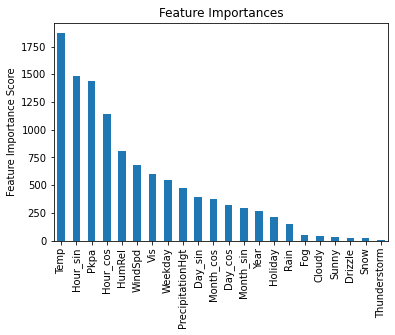

In [ ]:
# Basic model with new cyclical features
xgb_CC1_Y = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=3,
    n_estimators=5000,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
) 

# Show fit (initial - Volume)
modelfit2(xgb_CC1_Y,X_train,Y1_train,X_test,Y1_test)

# Show fit (initial - Duration)
modelfit2(xgb_CC1_Y,X_train,Y2_train,X_test,Y2_test)


### 2.1.1. Hyperparameter tuning of XGBoost

Below is the code required for the hyperparameter tuning of XGBoost. The detailed steps are explained in the team's report, also available on GitHub.

In short, it is a sequence of Grid searches and model updates in 4 steps:
* Grid search and update for max_depth and min_child_weight
* Grid search and update for the regularization parameter gamma
* Grid search and update for sampling hyperparameters (colsample_bytree, subsample)
* Update to the algorithm's learning rate

In [ ]:
# Step 1: max_depth,min_child_weight

# The parameters we want to test:
param_test1 = {
 'max_depth':[2, 3, 4, 5],
 'min_child_weight':[1, 5, 10, 20]
}

# Automatic grid search!
gsearch1v = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=3,
    n_estimators=1711,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch1v.fit(X_train,Y1_train)

# Display results
print("Best: %f using %s" % (gsearch1v.best_score_, gsearch1v.best_params_))
means = gsearch1v.cv_results_['mean_test_score']
params = gsearch1v.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))
    
# -----------------------------------------------------
    
# Automatic grid search!
gsearch1d = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=3,
    n_estimators=1711,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch1d.fit(X_train,Y2_train)

# Display results
print("Best: %f using %s" % (gsearch1d.best_score_, gsearch1d.best_params_))
means = gsearch1d.cv_results_['mean_test_score']
params = gsearch1d.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -147.077721 using {'max_depth': 5, 'min_child_weight': 5}
-259.747411 with: {'max_depth': 2, 'min_child_weight': 1}
-261.132853 with: {'max_depth': 2, 'min_child_weight': 5}
-259.936547 with: {'max_depth': 2, 'min_child_weight': 10}
-261.088062 with: {'max_depth': 2, 'min_child_weight': 20}
-178.718325 with: {'max_depth': 3, 'min_child_weight': 1}
-178.799630 with: {'max_depth': 3, 'min_child_weight': 5}
-180.065278 with: {'max_depth': 3, 'min_child_weight': 10}
-181.025180 with: {'max_depth': 3, 'min_child_weight': 20}
-157.262826 with: {'max_depth': 4, 'min_child_weight': 1}
-156.489715 with: {'max_depth': 4, 'min_child_weight': 5}
-157.909196 with: {'max_depth': 4, 'min_child_weight': 10}
-159.541359 with: {'max_depth': 4, 'min_child_weight': 20}
-147.129413 with: {'max_depth': 5, 'min_child_weight': 1}
-147.077721 with: {'max_depth': 5, 'min_child_weight': 5}
-148.691072 with: {'max_depth': 5, 'min_child_weight': 10}
-149.866720 with: {'max_depth': 5, 'min_child_weight': 20}



Model Report:
Best number of estimators: 980
Full Training Set RMSE : 65.19
Test Set RMSE : 140.48

Model Report:
Best number of estimators: 480
Full Training Set RMSE : 52.68
Test Set RMSE : 57.39


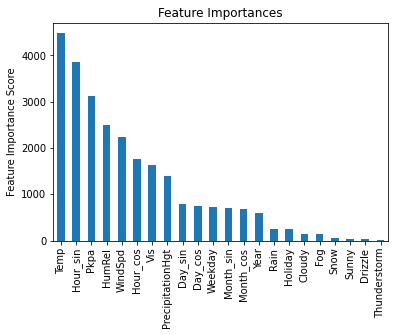

In [ ]:
# First update VOLUME
xgb_CC2_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=5,
    n_estimators=5000,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC2_Y1,X_train,Y1_train,X_test,Y1_test)

# -----------------------------

# First update DURATION
xgb_CC2_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=3,
    n_estimators=5000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC2_Y2,X_train,Y2_train,X_test,Y2_test)

In [ ]:
# GAMMA

# The parameters we want to test:
param_test2 = {
 'gamma':[0.1, 1, 5, 10, 20, 50]
}

# Automatic grid search!
gsearch2v = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=5,
    n_estimators=980,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
), 
 param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch2v.fit(X_train,Y1_train)

# Display results
print("Best: %f using %s" % (gsearch2v.best_score_, gsearch2v.best_params_))
means = gsearch2v.cv_results_['mean_test_score']
params = gsearch2v.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))
    
# -----------------------------------------------------
    
# Automatic grid search!
gsearch2d = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=1,                 
    eta=0.1,
    max_depth=3,
    n_estimators=480,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
), 
 param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch2d.fit(X_train,Y2_train)

# Display results
print("Best: %f using %s" % (gsearch2d.best_score_, gsearch2d.best_params_))
means = gsearch2d.cv_results_['mean_test_score']
params = gsearch2d.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -148.822971 using {'gamma': 50}
-149.190437 with: {'gamma': 0.1}
-149.190437 with: {'gamma': 1}
-149.190437 with: {'gamma': 5}
-148.864384 with: {'gamma': 10}
-148.961360 with: {'gamma': 20}
-148.822971 with: {'gamma': 50}
Best: -59.088091 using {'gamma': 50}
-59.149337 with: {'gamma': 0.1}
-59.149337 with: {'gamma': 1}
-59.121351 with: {'gamma': 5}
-59.121142 with: {'gamma': 10}
-59.103254 with: {'gamma': 20}
-59.088091 with: {'gamma': 50}



Model Report:
Best number of estimators: 893
Full Training Set RMSE : 68.98
Test Set RMSE : 141.41

Model Report:
Best number of estimators: 454
Full Training Set RMSE : 52.94
Test Set RMSE : 57.55


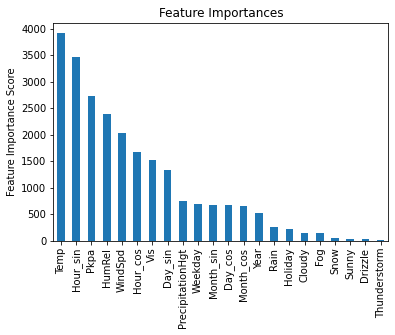

In [ ]:
# Second update VOLUME
xgb_CC3_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    eta=0.1,
    max_depth=5,
    n_estimators=5000,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC3_Y1,X_train,Y1_train,X_test,Y1_test)

# -----------------------------

# Second update DURATION
xgb_CC3_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    eta=0.1,
    max_depth=3,
    n_estimators=5000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC3_Y2,X_train,Y2_train,X_test,Y2_test)

In [ ]:
# SAMPLING

# The parameters we want to test:
param_test3 = {
 'subsample':[0.6,0.7,0.8,0.9],
 'colsample_bytree':[0.4,0.6,0.8,1]
}

# Automatic grid search!
gsearch3v = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    eta=0.1,
    max_depth=5,
    n_estimators=893,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
), 
 param_grid = param_test3, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch3v.fit(X_train,Y1_train)

# Display results
print("Best: %f using %s" % (gsearch3v.best_score_, gsearch3v.best_params_))
means = gsearch3v.cv_results_['mean_test_score']
params = gsearch3v.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))
    
# -----------------------------------------------------
    
# Automatic grid search!
gsearch3d = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    eta=0.1,
    max_depth=3,
    n_estimators=454,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
), 
 param_grid = param_test3, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch3d.fit(X_train,Y2_train)

# Display results
print("Best: %f using %s" % (gsearch3d.best_score_, gsearch3d.best_params_))
means = gsearch3d.cv_results_['mean_test_score']
params = gsearch3d.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -145.815604 using {'colsample_bytree': 1, 'subsample': 0.7}
-168.131919 with: {'colsample_bytree': 0.4, 'subsample': 0.6}
-164.942227 with: {'colsample_bytree': 0.4, 'subsample': 0.7}
-162.312331 with: {'colsample_bytree': 0.4, 'subsample': 0.8}
-162.836147 with: {'colsample_bytree': 0.4, 'subsample': 0.9}
-155.928362 with: {'colsample_bytree': 0.6, 'subsample': 0.6}
-152.592578 with: {'colsample_bytree': 0.6, 'subsample': 0.7}
-151.535814 with: {'colsample_bytree': 0.6, 'subsample': 0.8}
-152.253394 with: {'colsample_bytree': 0.6, 'subsample': 0.9}
-151.260295 with: {'colsample_bytree': 0.8, 'subsample': 0.6}
-150.058052 with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-149.390097 with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-151.036835 with: {'colsample_bytree': 0.8, 'subsample': 0.9}
-148.271188 with: {'colsample_bytree': 1, 'subsample': 0.6}
-145.815604 with: {'colsample_bytree': 1, 'subsample': 0.7}
-148.042575 with: {'colsample_bytree': 1, 'subsample': 0.8}
-148.82581


Model Report:
Best number of estimators: 898
Full Training Set RMSE : 66.92
Test Set RMSE : 143.51

Model Report:
Best number of estimators: 445
Full Training Set RMSE : 53.47
Test Set RMSE : 57.65


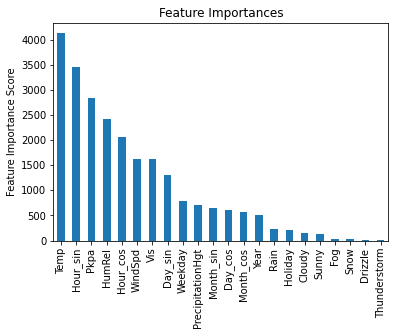

In [ ]:
# Third update VOLUME
xgb_CC4_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    eta=0.1,
    max_depth=5,
    n_estimators=5000,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=1,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC4_Y1,X_train,Y1_train,X_test,Y1_test)

# -----------------------------

# Third update DURATION
xgb_CC4_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    eta=0.1,
    max_depth=3,
    n_estimators=5000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC4_Y2,X_train,Y2_train,X_test,Y2_test)


Model Report:
Best number of estimators: 6325
Full Training Set RMSE : 77.46
Test Set RMSE : 137.86

Model Report:
Best number of estimators: 3698
Full Training Set RMSE : 54.12
Test Set RMSE : 57.33


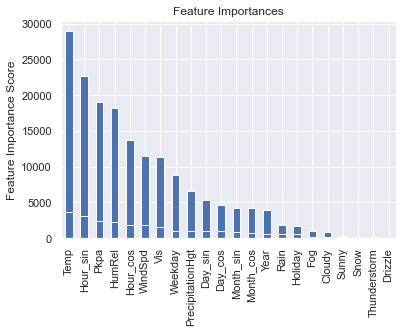

In [ ]:
# Let's reduce the learning rate for the final update:

# Last update VOLUME
xgb_CC5_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    learning_rate=0.01,
    max_depth=5,
    n_estimators=10000,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=1,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC5_Y1,X_train,Y1_train,X_test,Y1_test)

# -----------------------------

# Last update DURATION
xgb_CC5_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=10,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=1
) 

# Show fit
modelfit2(xgb_CC5_Y2,X_train,Y2_train,X_test,Y2_test)

Text(0, 0.5, 'Feature Importance Score')

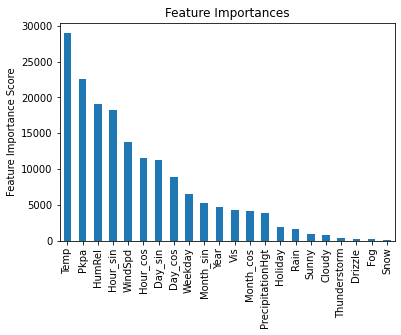

In [ ]:
    feat_imp = pd.Series(xgb_CC5_Y1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

The two features above show the feature importance maps for both target variables for the fitted XGBoost models. The final fitted models are:
* xgb_CC5_Y1, for the Volume target variable
* xgb_CC5_Y2, for the Duration target variable

## 2.2. Neural Networks, using Sci-Kit Learn's MLP

In this second modeling part of the project, the team uses Sci-Kit Learn's MLP and pits it against XGBoost.

According to the literature review conducted and the caracteristics of the data, it was expected to underperform: though it couldn't match XGBoost in raw performance on the test set considered, it did overfit less - so it's not all bad and could be interesting to explore how it can exploit more data.

The following cells complete additional required pre-processing steps, including:
* Missing values treatment
* Data standardization

In [ ]:
# I need to check for nans
X_train.isna().any()

# I need to impute by mean for Vis, replace nans by 0 for PrecipitationHgt
X_train['PrecipitationHgt'] = X_train['PrecipitationHgt'].fillna(0)
X_test['PrecipitationHgt'] = X_test['PrecipitationHgt'].fillna(0)

X_train['Vis'] = X_train['Vis'].fillna(X_train['Vis'].mean())
X_test['Vis'] = X_test['Vis'].fillna(X_test['Vis'].mean())

In [ ]:
# Since it's a neural network, I will scale the data. UNlike xgboost, it is not handled automatically!
from sklearn.preprocessing import StandardScaler
scaler_all = StandardScaler()
# Training
scaler_all.fit(X_train)
X_train = scaler_all.transform(X_train)
# Test
X_test = scaler_all.transform(X_test)

Just like for XGBoost, a small function is created to evaluate to performance using cross-validation.

It's the function below called cvprint() - it will be used throughout this section.

In [ ]:
def cvprint(model,X,Y):
    cv_results = cross_validate(model,X,Y,n_jobs=-1,scoring='neg_root_mean_squared_error',return_train_score=True)
    # Returns valid RMSE, train RMSE
    return -1*cv_results['test_score'].mean(), -1*cv_results['train_score'].mean()

The cells below define the reference model, which was trained with semi-random/standard parameters. Its performance for both target variable is recorded for future comparison.

In [ ]:
# Reference model
ref_model = MLPRegressor(hidden_layer_sizes=(20,20),
                         learning_rate='constant',
                         activation='relu',
                         alpha=0.0001,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=0.001)

In [ ]:
ref_model.fit(X_train,Y1_train)
predictions = ref_model.predict(X_test)
print("RMSE (Test) : %.2f" % sqrt(metrics.mean_squared_error(Y1_test.values, predictions)))

RMSE (Test) : 190.87


In [ ]:
ref_model.fit(X_train,Y2_train)
predictions = ref_model.predict(X_test)
print("RMSE (Test) : %.2f" % sqrt(metrics.mean_squared_error(Y2_test.values, predictions)))

RMSE (Test) : 61.73


In [ ]:
valid_rmse, train_rmse = cvprint(ref_model,X_train,Y1_train)
print(valid_rmse)
print(train_rmse)

174.66707596523312
153.92942520040216


### 2.2.1. Hyperparameter tuning

In a first step, different hyperparameter ranges are tested for the most important hyperparameters. The optimal looking ranges will be selected and used in a grid search in the next step. This pre-search allows for a quicker grid search. The hyperparameter tested are:
* Number of layers
* Neurons per layer
* Learning rate algorithm and initialization
* Alpha (regularization parameter)

The cells below show this search for the second target variable, Y2.

The same process can be applied to the first target variable Y1 - results are shown in our report.

[71.90919741558486, 69.01848466271902, 68.22836652674309, 67.62520534680628, 66.53158348575337, 65.97027345167969]
[69.27359181739041, 65.43200288913454, 64.81449091432924, 64.00634311893648, 62.695028075153246, 61.848020518990246]


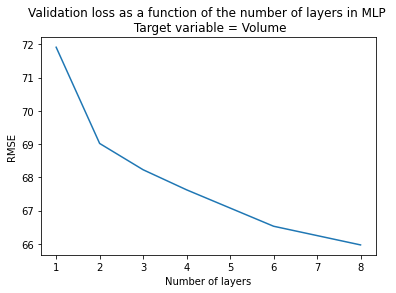

In [ ]:
# Layer number
V_RMSE = []
T_RMSE = []

for hidden_layer_sizes in [(20,),(20,20),(20,20,20),(20,20,20,20),(20,20,20,20,20,20),(20,20,20,20,20,20,20,20)]: 
    v = []
    t = []
    i = 0
    while i < 5:
        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                 learning_rate='constant',
                                 activation='relu',
                                 alpha=0.0001,
                                 max_iter=5000, 
                                 early_stopping=True,
                                 validation_fraction=0.2,
                                 learning_rate_init=0.001)
        valid_rmse, train_rmse = cvprint(model,X_train,Y2_train)
        v.append(valid_rmse)
        t.append(train_rmse)
        i = i+1
    V_RMSE.append(np.array(v).mean())
    T_RMSE.append(np.array(t).mean())
    

hidden_layer_size = [1,2,3,4,6,8] #,6,8
plt.figure()
plt.plot(hidden_layer_size,V_RMSE, label='Validation')
plt.title('Validation loss as a function of the number of layers in MLP \n Target variable = Volume')
plt.xlabel('Number of layers')
plt.ylabel('RMSE')
print(V_RMSE)
print(T_RMSE)

[73.75026504199427, 71.23781747739437, 69.11416519156636, 65.41006050822743, 63.95932510699172]
[72.4452454051295, 68.88381547501197, 65.33950236011417, 59.48719599886418, 56.57596266131367]


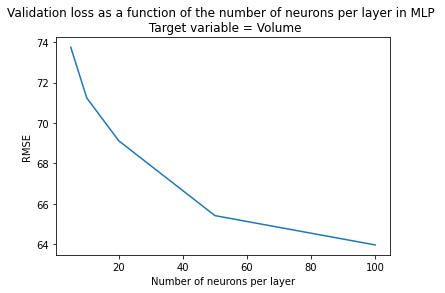

In [ ]:
# Neurons
V_RMSE = []
T_RMSE = []

for x in [5,10,20,50,100]: 
    v = []
    t = []
    i = 0
    while i < 5:
        model = MLPRegressor(hidden_layer_sizes=(x,x),
                         learning_rate='constant',
                         activation='relu',
                         alpha=0.0001,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=0.001)
        valid_rmse, train_rmse = cvprint(model,X_train,Y2_train)
        v.append(valid_rmse)
        t.append(train_rmse)
        i = i+1
    V_RMSE.append(np.array(v).mean())
    T_RMSE.append(np.array(t).mean())
    

neurons = [5,10,20,50,100] 
plt.figure()
plt.plot(neurons,V_RMSE, label='Validation')
plt.title('Validation loss as a function of the number of neurons per layer in MLP \n Target variable = Volume')
plt.xlabel('Number of neurons per layer')
plt.ylabel('RMSE')
print(V_RMSE)
print(T_RMSE)

[68.7547133193773, 69.11708911934787, nan]
[64.99770019405778, 65.33625430361296, nan]


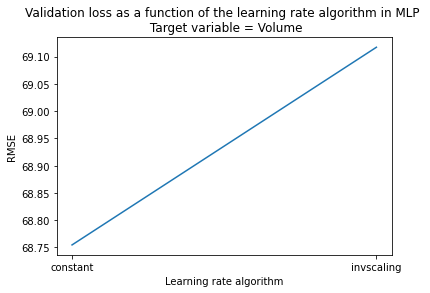

In [ ]:
# Learning Rate
V_RMSE = []
T_RMSE = []

for learning_rate in ['constant','invscaling','adaptative']: 
    v = []
    t = []
    i = 0
    while i < 5:
        model = MLPRegressor(hidden_layer_sizes=(20,20),
                         learning_rate=learning_rate,
                         activation='relu',
                         alpha=0.0001,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=0.001)
        valid_rmse, train_rmse = cvprint(model,X_train,Y2_train)
        v.append(valid_rmse)
        t.append(train_rmse)
        i = i+1
    V_RMSE.append(np.array(v).mean())
    T_RMSE.append(np.array(t).mean())
    

learning = ['constant','invscaling','adaptative']
plt.figure()
plt.plot(learning,V_RMSE, label='Validation')
plt.title('Validation loss as a function of the learning rate algorithm in MLP \n Target variable = Volume')
plt.xlabel('Learning rate algorithm')
plt.ylabel('RMSE')
print(V_RMSE)
print(T_RMSE)

[68.14196561574491, 68.56807733287744, 68.55680547773594, 69.17948164606571, 68.82298342466784]
[64.18937489606728, 64.90787332520115, 64.76769733016872, 65.498819091366, 65.09720772420769]


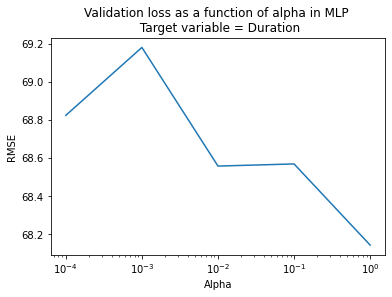

In [ ]:
# Alpha
V_RMSE = []
T_RMSE = []

for alpha in [1,0.1,0.01,0.001,0.0001]:
    v = []
    t = []
    i = 0
    while i < 5:
        model = MLPRegressor(hidden_layer_sizes=(20,20),
                         learning_rate='constant',
                         activation='relu',
                         alpha=alpha,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=0.001)
        valid_rmse, train_rmse = cvprint(model,X_train,Y2_train)
        v.append(valid_rmse)
        t.append(train_rmse)
        i = i+1
    V_RMSE.append(np.array(v).mean())
    T_RMSE.append(np.array(t).mean())
    

alpha = [1,0.1,0.01,0.001,0.0001]
plt.figure()
plt.plot(alpha,V_RMSE, label='Validation')
plt.xscale('log')
plt.title('Validation loss as a function of alpha in MLP \n Target variable = Duration')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
print(V_RMSE)
print(T_RMSE)

[117.79366833177508, 87.70561052275252, 68.95159905198436, 66.99963581706028, 68.8751130118576]
[117.78963747816417, 85.32660282233095, 65.41046511980463, 63.15040078594649, 65.23876804872525]


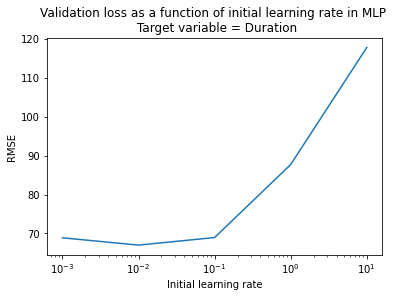

In [ ]:
# Learning rate init
V_RMSE = []
T_RMSE = []

for learning_rate_init in [10,1,0.1,0.01,0.001]:
    v = []
    t = []
    i = 0
    while i < 5:
        model = MLPRegressor(hidden_layer_sizes=(20,20),
                         learning_rate='constant',
                         activation='relu',
                         alpha=0.0001,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=learning_rate_init)
        valid_rmse, train_rmse = cvprint(model,X_train,Y2_train)
        v.append(valid_rmse)
        t.append(train_rmse)
        i = i+1
    V_RMSE.append(np.array(v).mean())
    T_RMSE.append(np.array(t).mean())
    

init = [10,1,0.1,0.01,0.001]
plt.figure()
plt.plot(init,V_RMSE, label='Validation')
plt.xscale('log')
plt.title('Validation loss as a function of initial learning rate in MLP \n Target variable = Duration')
plt.xlabel('Initial learning rate')
plt.ylabel('RMSE')
print(V_RMSE)
print(T_RMSE)

Once this pre-search is completed, the grid search may begin.

The implementation of this grid search and evaluation of the best model is done through the function mlp_model_volume() below for the first target variable, and through mlp_model_duration() for the second.

Both functions return the best model at the end of their search.

In [ ]:
def mlp_model_volume(X, Y):

    estimator=MLPRegressor()

    param_grid = {'hidden_layer_sizes': [(20,20), (20,20,20), (20,20,20,20), (50,50), (50,50,50), (50,50,50,50)],
              'alpha': [0.1,1],
              'learning_rate': ['invscaling'],
              'learning_rate_init':[0.1,0.01],
              'solver': ['adam']}

    gsc = GridSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)

    best_params = grid_result.best_params_


    # Display GS results
    print("Best: %f using %s" % (gsc.best_score_, gsc.best_params_))
    means = gsc.cv_results_['mean_test_score']
    params = gsc.cv_results_['params']
    for mean, param in zip(means, params):
        print("%f with: %r" % (mean, param))
    
    # Test best model
    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation ='relu',
                        alpha = best_params["alpha"],    
                        solver='adam',
                        max_iter= 5000, 
                        early_stopping=True, 
                        learning_rate='invscaling',
                        learning_rate_init=best_params["learning_rate_init"]
              )
    
    scores = cross_validate(best_mlp,X,Y,n_jobs=-1,scoring='neg_root_mean_squared_error',return_train_score=True)
    print('RMSE (Valid.):',-1*scores['test_score'].mean())
    print('RMSE (Train):',-1*scores['train_score'].mean())
    return best_mlp

In [ ]:
def mlp_model_duration(X, Y):

    estimator=MLPRegressor()

    param_grid = {'hidden_layer_sizes': [(50,50,50), (50,50,50,50),(50,50,50,50,50,50), (100,100,100), (100,100,100,100), (100,100,100,100,100,100)],
              'alpha': [0.1,1],
              'learning_rate_init':[0.1,0.01,0.001],
              'solver': ['adam']}

    gsc = GridSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)

    best_params = grid_result.best_params_


    # Display GS results
    print("Best: %f using %s" % (gsc.best_score_, gsc.best_params_))
    means = gsc.cv_results_['mean_test_score']
    params = gsc.cv_results_['params']
    for mean, param in zip(means, params):
        print("%f with: %r" % (mean, param))
    
    # Test best model
    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation ='relu',
                        alpha = best_params["alpha"],    
                        solver='adam',
                        max_iter= 5000, 
                        early_stopping=True,
                        learning_rate='constant',
                        learning_rate_init=best_params["learning_rate_init"]
              )
    
    scores = cross_validate(best_mlp,X,Y,n_jobs=-1,scoring='neg_root_mean_squared_error',return_train_score=True)
    print('RMSE (Valid.):',-1*scores['test_score'].mean())
    print('RMSE (Train):',-1*scores['train_score'].mean())
    return best_mlp

The grid search is applied to the first target variable (Y1, Volume)

In [ ]:
best_nn_volume = mlp_model_volume(X_train,Y1_train)

Best: -27784.451810 using {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'solver': 'adam'}
-34684.830519 with: {'alpha': 0.1, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'solver': 'adam'}
-32823.228252 with: {'alpha': 0.1, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'solver': 'adam'}
-37076.338635 with: {'alpha': 0.1, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'solver': 'adam'}
-31345.896532 with: {'alpha': 0.1, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'solver': 'adam'}
-32494.080750 with: {'alpha': 0.1, 'hidden_layer_sizes': (20, 20, 20, 20), 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'solver': 'adam'}
-32482.993510 with: {'alpha': 0.1, 'hidden_layer_sizes': (20, 20, 20, 20), 'learning_rate': 'invscaling', 'le

And to the second target variable (Y2, Duration)

In [ ]:
best_nn_duration = mlp_model_duration(X_train,Y2_train)

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best: -4009.411231 using {'alpha': 1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.001, 'solver': 'adam'}
-4388.239823 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.1, 'solver': 'adam'}
-4376.654531 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
-4085.002343 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
-4231.406817 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.1, 'solver': 'adam'}
-4251.899567 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
-4045.874918 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
-8482.704579 with: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50, 50, 50, 50), 'learning_rate_init': 0.1, 'solver': 'adam'}
-4148.194213 with: {'alpha': 0.1, 'hidden

Finally, the best models (best_nn_volume and best_nn_duration) are tested on the test set that had been set aside for evaluation purposes until then. The hyperparameter tuning increases the model performance in both cases, when compared to the reference model.

In [ ]:
# Volume
best_nn_volume = MLPRegressor(hidden_layer_sizes=(50,50,50,50),
                         learning_rate='invscaling',
                         activation='relu',
                         alpha=0.1,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=0.01)
best_nn_volume.fit(X_train,Y1_train)
predictions = best_nn_volume.predict(X_test)
print("RMSE (Test) : %.2f" % sqrt(metrics.mean_squared_error(Y1_test.values, predictions)))

RMSE (Test) : 163.58


In [ ]:
# Duration
best_nn_duration = MLPRegressor(hidden_layer_sizes=(100,100,100),
                         learning_rate='constant',
                         activation='relu',
                         alpha=1,
                         max_iter=5000, 
                         early_stopping=True,
                         validation_fraction=0.2,
                         learning_rate_init=0.001)
best_nn_duration.fit(X_train,Y2_train)
predictions = best_nn_duration.predict(X_test)
print("RMSE (Test) : %.2f" % sqrt(metrics.mean_squared_error(Y2_test.values, predictions)))

RMSE (Test) : 59.68


## 2.3. Plots
The last part of this section is plots - all results are plotted. The results from XGBoost and from the MLP will be compared, and both test and training points will be shown to analyze overfitting, if applicable.

The results will be presented for two 3-day periods, chosen semi-randomly:
* Thursday, October 4 2018 - Satuday, October 6 2018 : a regular work week
* Sunday, June 23 2019 - Tuesday, June 25 2019 : summer holidays

The two cells below were used to flag training and testing points for subsequent plotting. They also select the date ranges of interest, so that we are able to make predictions on those specific time periods.

In [ ]:
# Code to find which points are training points
train_data = X_train
# loaded once train_data with correct X_train - don't run again!
train_data['train'] = 1
train_data = train_data['train']
train_data.to_frame()

,train
dateIDh,
2019082607,1
2017060618,1
2018100919,1
2019091123,1
2019070718,1
...,...
2019061916,1
2018051504,1
2019042620,1


In [ ]:
# First I need to get the points I need for volume and duration based on time, and identify which is test, which is train.
# Second I need to make sure the data is in the right format for each model
# Third I make predictions
# Finally, I make plots!

raw_work = hourly_2019[(hourly_2019['dateIDd'] >= 20181004) & (hourly_2019['dateIDd'] <= 20181006)]
raw_holiday = hourly_2019[(hourly_2019['dateIDd'] >= 20190623) & (hourly_2019['dateIDd'] <= 20190625)]

# ajouter ici la division train/test
observed_work = raw_work[['Duration','Volume']]
observed_work_train = pd.merge(observed_work, train_data, left_index=True, right_index=True, how='left')
observed_work_train['train'] = observed_work_train['train'].fillna(0)
observed_work_train['time'] = range(len(observed_work))
observed_holiday = raw_holiday[['Duration','Volume']]
observed_holiday_train = pd.merge(observed_holiday, train_data, left_index=True, right_index=True, how='left')
observed_holiday_train['train'] = observed_holiday_train['train'].fillna(0)
observed_holiday_train['time'] = range(len(observed_holiday))

# BETTER: pd.date_range(start="2018-09-09",end="2020-02-02")

# Time encoding
raw_work = encode(raw_work,'Month',12)
raw_work = encode(raw_work,'Day',31)
raw_work = encode(raw_work,'Hour',23)
raw_holiday = encode(raw_holiday,'Month',12)
raw_holiday = encode(raw_holiday,'Day',31)
raw_holiday = encode(raw_holiday,'Hour',23)

# xgb data prep
X_xg_work = raw_work.drop(['dateIDd', 'dateIDm', 'Hmdx', 'Hour', 'Day', 'Month', 'Duration', 'Volume', 'DewPoint', 'WindDir', 'WindChill'], axis=1)
X_xg_holiday = raw_holiday.drop(['dateIDd', 'dateIDm', 'Hmdx', 'Hour', 'Day', 'Month', 'Duration', 'Volume', 'DewPoint', 'WindDir', 'WindChill'], axis=1)

# Pour le nn 
# données manquantes
X_nn_work = X_xg_work
X_nn_work['PrecipitationHgt'] = X_nn_work['PrecipitationHgt'].fillna(0)
X_nn_work['Vis'] = X_nn_work['Vis'].fillna(X_nn_work['Vis'].mean())
X_nn_holiday = X_xg_holiday
X_nn_holiday['PrecipitationHgt'] = X_nn_holiday['PrecipitationHgt'].fillna(0)
X_nn_holiday['Vis'] = X_nn_holiday['Vis'].fillna(X_nn_holiday['Vis'].mean())
# uiliser scaler_all pour scale (pas fit un nouveau scaler)
X_nn_work = scaler_all.transform(X_nn_work)
X_nn_holiday = scaler_all.transform(X_nn_holiday)

Predictions are computed using the best models trained in sections 2.1 and 2.2.

In [ ]:
# predicting
predicted_xgb_work_volume = xgb_CC5_Y1.predict(X_xg_work)
predicted_xgb_work_duration = xgb_CC5_Y2.predict(X_xg_work)
predicted_nn_work_volume = best_nn_volume.predict(X_nn_work)
predicted_nn_work_duration = best_nn_duration.predict(X_nn_work)

predicted_xgb_holiday_volume = xgb_CC5_Y1.predict(X_xg_holiday)
predicted_xgb_holiday_duration = xgb_CC5_Y2.predict(X_xg_holiday)
predicted_nn_holiday_volume = best_nn_volume.predict(X_nn_holiday)
predicted_nn_holiday_duration = best_nn_duration.predict(X_nn_holiday)

Finally:

The results are plotted. 4 plots will be shown:
* Work week, BIXI bike rides recorded (target variable 1)
* Holidays, BIXI bike rides recorded (target variable 1)
* Work week, average trip duration (target variable 2)
* Holidays, average trip duration (target variable 2)

([<matplotlib.axis.XTick at 0x1b8f4445e48>,
 [Text(0, 0, '0h \n Thursday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Friday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Saturday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h')])

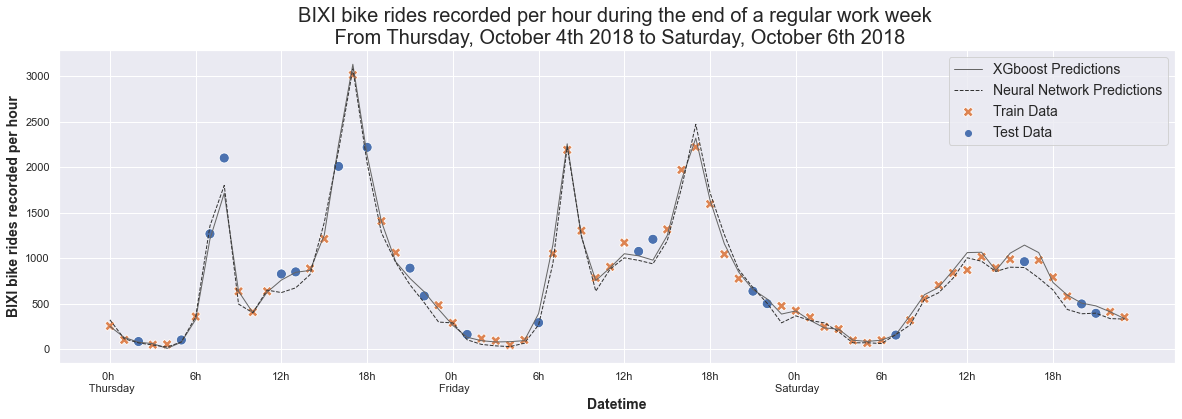

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5.75)})
fg = sns.scatterplot(x="time", y="Volume", hue="train", style="train", s=100, data=observed_work_train)
plt.plot(observed_work_train['time'],predicted_xgb_work_volume, label='XGboost Predictions', linewidth=1, c='0.4')
plt.plot(observed_work_train['time'],predicted_nn_work_volume, label='Neural Network Predictions', linewidth=1, c='0.2', linestyle='--')
plt.legend(['XGboost Predictions','Neural Network Predictions','Train Data','Test Data'], fontsize=14)
plt.title('BIXI bike rides recorded per hour during the end of a regular work week \n From Thursday, October 4th 2018 to Saturday, October 6th 2018', fontsize=20)
plt.xlabel('Datetime', fontweight="bold", fontsize=14)
plt.ylabel('BIXI bike rides recorded per hour', fontweight="bold", fontsize=14)
plt.xticks(range(0,72,6), ['0h \n Thursday','6h', '12h', '18h','0h \n Friday','6h', '12h', '18h',
                                   '0h \n Saturday','6h', '12h', '18h','0h \n Sunday'], rotation=0)

([<matplotlib.axis.XTick at 0x1b8819780b8>,
 [Text(0, 0, '0h \n Sunday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Monday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Tuesday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h')])

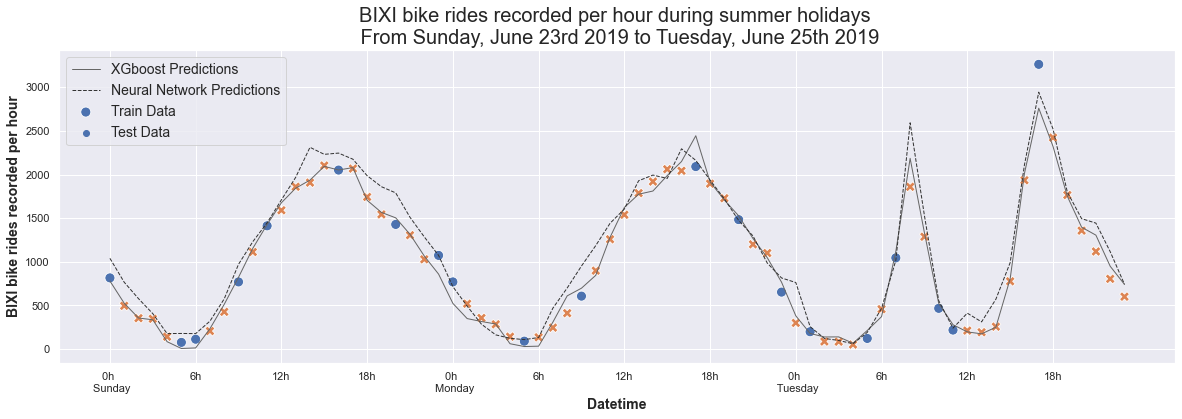

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5.75)})
fg2 = sns.scatterplot(x="time", y="Volume", hue="train", style="train", s=100, data=observed_holiday_train)
plt.plot(observed_holiday_train['time'],predicted_xgb_holiday_volume, label='XGboost Predictions', linewidth=1, c='0.4')
plt.plot(observed_holiday_train['time'],predicted_nn_holiday_volume, label='Neural Network Predictions', linewidth=1, c='0.2', linestyle='--')
plt.legend(['XGboost Predictions','Neural Network Predictions','Train Data','Test Data'], fontsize=14)
plt.title('BIXI bike rides recorded per hour during summer holidays \n From Sunday, June 23rd 2019 to Tuesday, June 25th 2019', fontsize=20)
plt.xlabel('Datetime', fontweight="bold", fontsize=14)
plt.ylabel('BIXI bike rides recorded per hour', fontweight="bold", fontsize=14)
plt.xticks(range(0,72,6), ['0h \n Sunday','6h', '12h', '18h', 
                                   '0h \n Monday','6h', '12h', '18h','0h \n Tuesday','6h', '12h', '18h'], rotation=0)

([<matplotlib.axis.XTick at 0x1b8822d8278>,
 [Text(0, 0, '0h \n Thursday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Friday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Saturday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h')])

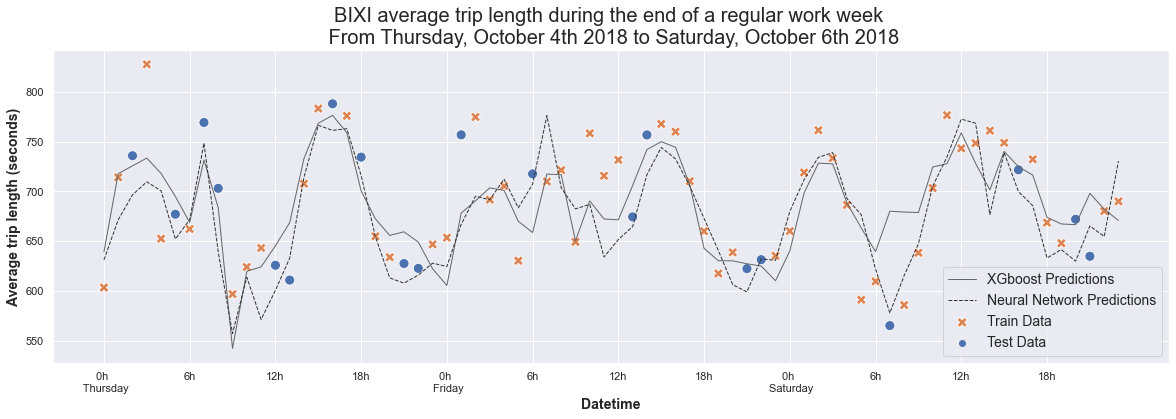

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5.75)})
fg3 = sns.scatterplot(x="time", y="Duration", hue="train", style="train", s=100, data=observed_work_train)
plt.plot(observed_work_train['time'],predicted_xgb_work_duration, label='XGboost Predictions', linewidth=1, c='0.4')
plt.plot(observed_work_train['time'],predicted_nn_work_duration, label='Neural Network Predictions', linewidth=1, c='0.2', linestyle='--')
plt.legend(['XGboost Predictions','Neural Network Predictions','Train Data','Test Data'], fontsize=14)
plt.title('BIXI average trip length during the end of a regular work week \n From Thursday, October 4th 2018 to Saturday, October 6th 2018', fontsize=20)
plt.xlabel('Datetime', fontweight="bold", fontsize=14)
plt.ylabel('Average trip length (seconds)', fontweight="bold", fontsize=14)
plt.xticks(range(0,72,6), ['0h \n Thursday','6h', '12h', '18h','0h \n Friday','6h', '12h', '18h',
                                   '0h \n Saturday','6h', '12h', '18h','0h \n Sunday'], rotation=0)

([<matplotlib.axis.XTick at 0x1b88234bba8>,
 [Text(0, 0, '0h \n Sunday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Monday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h'),
  Text(0, 0, '0h \n Tuesday'),
  Text(0, 0, '6h'),
  Text(0, 0, '12h'),
  Text(0, 0, '18h')])

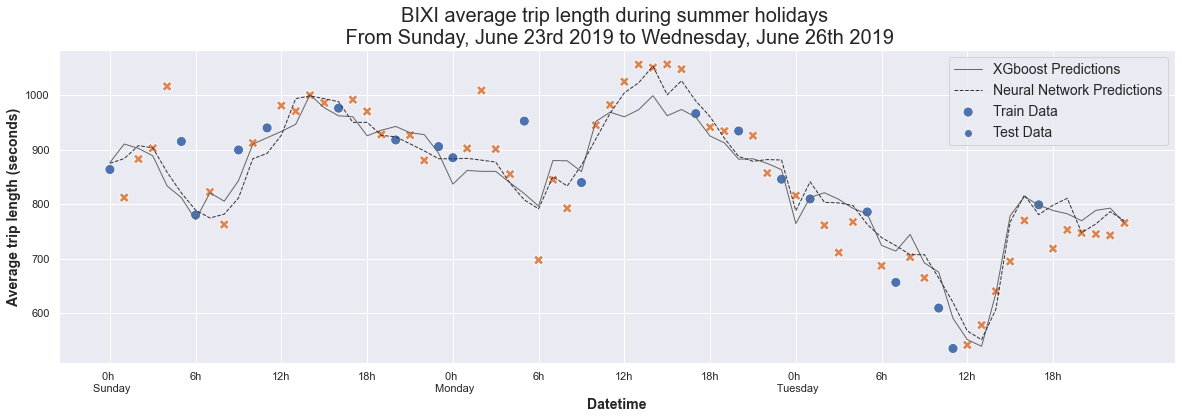

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5.75)})
fg4 = sns.scatterplot(x="time", y="Duration", hue="train", style="train", s=100, data=observed_holiday_train)
plt.plot(observed_holiday_train['time'],predicted_xgb_holiday_duration, label='XGboost Predictions', linewidth=1, c='0.4')
plt.plot(observed_holiday_train['time'],predicted_nn_holiday_duration, label='Neural Network Predictions', linewidth=1, c='0.2', linestyle='--')
plt.legend(['XGboost Predictions','Neural Network Predictions','Train Data','Test Data'], fontsize=14)
plt.title('BIXI average trip length during summer holidays \n From Sunday, June 23rd 2019 to Wednesday, June 26th 2019', fontsize=20)
plt.xlabel('Datetime', fontweight="bold", fontsize=14)
plt.ylabel('Average trip length (seconds)', fontweight="bold", fontsize=14)
plt.xticks(range(0,72,6), ['0h \n Sunday','6h', '12h', '18h', 
                                   '0h \n Monday','6h', '12h', '18h','0h \n Tuesday','6h', '12h', '18h'], rotation=0)

# Part 3: Clustering and classifying stations per neighbourhood

In order to analyze the bike flows per neighbourhood, we will first try to create neighbourhood clusters for BIXI stations using their latitude and longitude. 

In this section we will try three methods:
- K-means
- DBSCAN 
- Classification model

## 3.1. Data pre-processing

In [ ]:
# We will ignore the variable 'code' and will use the Station_Key_ID as the primary key.
bixi_master_stations.head()

In [ ]:
# First, we see that there a lot of duplicates of the same stations.
bixi_master_stations.loc[bixi_master_stations['name']=='Square St-Louis']

# We are only interested in 2020 stations, so we will only keep Station_Key_ID starting with 2020. There are 640 stations.
bixi_master_stations = bixi_master_stations[bixi_master_stations['Station_Key_ID'].astype(str).str.startswith('2020')]
bixi_master_stations.tail()

In [ ]:
# We then plot the geographical points; good news: it indeed looks like the BIXI station map! 
plot_bixi_master_stations = plt.plot(bixi_master_stations['longitude'], bixi_master_stations['latitude'],
             marker='.', linewidth=0, color='#128128')
plot_bixi_master_stations = plt.grid(which='major', color='#cccccc', alpha=0.45)
plot_bixi_master_stations = plt.title ('Geographical distribution of BIXI stations', family='DejaVu Sans', fontsize=12)
plot_bixi_master_stations = plt.xlabel('Longitude')
plot_bixi_master_stations = plt.ylabel('Latitude')
plot_bixi_master_stations = plt.show()

In [ ]:
# We then create a new dataframe to only keep the variables Station_Key_ID, Longitude and Latitude for our clustering analysis
cluster_bixi_stations=bixi_master_stations.loc[:,['Station_Key_ID','latitude','longitude']]
cluster_bixi_stations.head()

## 3.2. K-means method

Firstly, we tried clustering the BIXI stations using an unsupervised learning technique, specifically the k-means method. To do so, we used the elbow method to evaluate an appropriate number of clusters.

In [ ]:
# We will validate the number of clusters by using the elbow method 
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = cluster_bixi_stations[['latitude']]
X_axis = cluster_bixi_stations[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize the graph -- we see that 3 or 4 clusters could be interesting.
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
# Compute K-means clustering using 4 clusters
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(cluster_bixi_stations[cluster_bixi_stations.columns[1:3]])
cluster_bixi_stations['cluster_label'] = kmeans.fit_predict(cluster_bixi_stations[cluster_bixi_stations.columns[1:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(cluster_bixi_stations[cluster_bixi_stations.columns[1:4]]) # Labels of each point
cluster_bixi_stations.tail(10)

In [ ]:
# Visualize the clusters and centroids 
cluster_bixi_stations.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Latitude', weight='bold')
plt.xticks(fontsize=8)
plt.ylabel('Longitude', weight='bold')

The k-means method did not produce the results we were hoping due to the non-spherical shape of Montreal neighbourhoods as well as different neighbourhood density.

## 3.3. DBSCAN

We then attempted to cluster the BIXI stations using another unsupervised learning technique, more specifically the dnesity-based clustering method (DBSCAN). This method is interesting in that it separates high density clusters from low density ones and can identify clusters of different shapres and sizes.

In [ ]:
# Source: https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/8891646194974755/2498144867240775/6439822263820045/latest.html
# We now create a new dataframe to only keep the variables Station_Key_ID, Longitude and Latitude for our clustering analysis
cluster_bixi_stations2=bixi_master_stations.loc[:,['Station_Key_ID','latitude','longitude']]
cluster_bixi_stations2.head()

In [ ]:
# We define the number of kilometers in one radiatio, which will be used to convert esp from km to radiation
kms_per_rad = 6371.0088

In [ ]:
# Then, we define a function to calculate the geographic coordinate centroid of a cluster of geographic points. This will be used later to calculate the centroids of DBSCAN cluster because Scikit-learn DBSCAN cluster class does not come with centroid attribute.
def get_centroid(cluster):
  """calculate the centroid of a cluster of geographic coordinate points
  Args:
    cluster coordinates, nx2 array-like (array, list of lists, etc) 
    n is the number of points(latitude, longitude)in the cluster.
  Return:
    geometry centroid of the cluster
    
  """
  cluster_ary = np.asarray(cluster)
  centroid = cluster_ary.mean(axis = 0)
  return centroid

# testing get_centroid function
test_cluster= [[ 43.70487299, -79.57753802], 
               [ 43.71138367, -79.56524418],
               [ 43.72616079, -79.57319998],
               [ 43.73547907, -79.56258364],
               [ 43.72070325, -79.57202018],
               [ 43.73126031, -79.5598719 ]]
test_centroid = get_centroid(test_cluster)
print(test_centroid)

In [ ]:
# Then we convert eps to radians for use by haversine
epsilon = 1/kms_per_rad

In [ ]:
# We extract intersection coordinates (latitude, longitude)
bixi_coords = cluster_bixi_stations2[['latitude', 'longitude']].values

In [ ]:
import time
from sklearn import metrics

start_time = time.time()
dbsc = (DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='euclidean')
        .fit(np.radians(bixi_coords)))
bixi_cluster_labels = dbsc.labels_

In [ ]:
# We get the number of clusters
num_clusters = len(set(dbsc.labels_))
print(num_clusters)

In [ ]:
# Print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(cluster_bixi_stations2), num_clusters, 100*(1 - float(num_clusters) / len(cluster_bixi_stations2)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(bixi_coords, bixi_cluster_labels)))


In [ ]:
# Turn the clusters into a pandas series, where each element is a cluster of points
dbsc_clusters = pd.Series([bixi_coords[bixi_cluster_labels==n] for n in range(num_clusters)])

In [ ]:
# Get centroid of each cluster
bixi_centroids = dbsc_clusters.map(get_centroid)
# Unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
cent_lats, cent_lons = zip(*bixi_centroids)
# From these lats/lons create a new df of one representative point for each cluster
centroids_pd = pd.DataFrame({'longitude':cent_lons, 'latitude':cent_lats})

print(centroids_pd)

In [ ]:
# Finally, plot the clusters and cluster centroid
fig, ax = plt.subplots(figsize=[20, 12])
bixi_scatter = ax.scatter(cluster_bixi_stations2['longitude'], cluster_bixi_stations2['latitude'], c=bixi_cluster_labels, cmap = cm.Dark2, edgecolor='None', alpha=0.7, s=120)
centroid_scatter = ax.scatter(centroids_pd['longitude'], centroids_pd['latitude'], marker='x', linewidths=2, c='k', s=50)
ax.set_title('BIXI neighbourhood clusters & centroids', fontsize = 20)
ax.set_xlabel('Longitude', fontsize=18, weight='bold')
ax.set_ylabel('Latitude', fontsize = 18, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend([bixi_scatter, centroid_scatter], ['BIXI stations', 'Neighbourhood Centroid'], loc='upper right', fontsize = 18)

As we can see from the plot above, 9 clusters were formed. However, since the majority of BIXI stations are concentrated near the downtown area, this resulted in one large central cluster and a few sparse "satellite" clusters, which did not help us segment the central neighbourhoods. Similar results were generated when reducing the epsilon to a smaller radius, which confirmed that this clustering method was not interesting given the task at hand.

## 3.4. Classification model

### 3.4.1. Model training and evaluation

Finally, we tried out a supervised technique. More specifically, our approach was to train a classification model and subsequently use it to predict the neighbourhood associated to each BIXI station. We used a dataset from the City of Montreal containing the latitude and longitude of 3100+ Montreal aadresses with their associated neighbourhood label.

In [ ]:
plt.style.use('ggplot') # This make plots look better

In [ ]:
!git clone https://github.com/gbincoletto/MATH80629A

In [ ]:
url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/Classification_Latitude_Longitude2.csv'
quartier = pd.read_csv(url)

In [ ]:
quartier.head(5)

In [ ]:
print(quartier.shape)
# We see that there are 3171 observations.

In [ ]:
print(quartier.groupby('Code').size())

In [ ]:
print (quartier.describe())
# We see that there are no missing values, or extreme values.

In [ ]:
quartier.plot.scatter(x="Longitude", y="Latitude", color='b')
plt.title('My Title')
plt.show()
# By plotting the latitude and longitude, we notice it indeed looks like the island of Montreal! There are however two big pockets (East end of Montreal and around PET Airport). 

In [ ]:
import matplotlib.ticker as ticker

g= sns.FacetGrid(quartier, 
    hue="Code").map(plt.scatter, "Longitude", "Latitude").add_legend()
plt.xticks(np.arange(-73.9, -73.4, step=0.1))
for ax in g.axes.flat:
    ax.set_ylabel(ax.get_ylabel(), fontsize=9, weight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontsize=9, weight='bold')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Montreal neighbourhoods', fontsize=10)
plt.show()
# Good news - from the plot below, we see that the neighbourhoods are clustered together in well defined groups!

In [ ]:
# Currently, all the data is encoded in a DataFrame, but sklearn doesn't work with pandas' DataFrames, so we need to extract the features and labels and convert them into numpy arrays instead.
labels = np.asarray(quartier.Code)

In [ ]:
# First, we want to remove all the feature columns that we don't want from the DataFrame. Now we only have the columns Latitude and Longitude left.
quartier_selected = quartier.drop(['Code', 'Arrondissement'], axis=1)
print(quartier_selected)

In [ ]:
# Since we want to use more than one column, we can't just simply use np.asarray(). Instead, we can use the to_dict() method together with sklearn's DictVectorizer.
quartier_features = quartier_selected.to_dict(orient='records')

In [ ]:
# The sklearn interface for using the DictVectorizer class is similar to that of the LabelEncoder. One notable difference is the .toarray() method that is used with fit_transform.
vec = DictVectorizer()
features = vec.fit_transform(quartier_features).toarray()

After pre-processing the data, our approach was to train two classification models using Sci-Kit Learn's RandomForestClassifier and SVC and then select the model with the higest test set accuracy to make predictions. We trained both models and evaluated their performance using 2 methods: 80% training and 20% testing split, and secondly, a 5-fold cross-validation.

#### a. RFC (train-test)

In [ ]:
# Now that we have numerical features and label arrays, there's only one thing left to do: split our data up into a training and a test set.
# Sometimes, with algorithms particularly prone to overfitting, you also have a validation set. We will try with only a training and test set for now.
# Data split (80% training and 20% test). 
# The value of the random_state is not really important as it's just a seed number, but the act of randomizing the data is important, because right now, the data i 
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, 
    test_size=0.2, random_state=0)

In [ ]:
# We will start out with a Random Forest classifier. Random Forests are simple, flexible in that they work well with a wide variety of data, and rarely overfit. One notable downside to Random Forests is that they are non-deterministic in nature, so they don't necessarily produce the same results every time you train them.
# Import
from sklearn.ensemble import RandomForestClassifier

# Initialize
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0,
                       verbose=0, warm_start=False)

# Train the classifier using the training data
clf.fit(features_train, labels_train)

In [ ]:
# Train the classifier using the training data
clf.fit(features_train, labels_train)

In [ ]:
# Compute accuracy using training data
acc_train = clf.score(features_train, labels_train)

print ("Train Accuracy:", acc_train)
# Train Accuracy: 100%

In [ ]:
# Compute accuracy using test data
acc_test = clf.score(features_test, labels_test)

print ("Test Accuracy:", acc_test)
# Test Accuracy: 93.8% - since this is less than the train accuracy, it suggests that the model slightly overfits, but the results are still quite good.

#### b. SVM (train-test)

In [ ]:
# Now let's try out an SVM. 
# Import
from sklearn.svm import SVC

# Initialize
svcclassifier = SVC(C=25, kernel='linear', decision_function_shape='ovo', random_state=0)

# Train the classifier using the training data
svcclassifier.fit(features_train, labels_train)

In [ ]:
# Compute accuracy using training data
acc_train = svcclassifier.score(features_train, labels_train)

print ("Train Accuracy:", acc_train)
# Train Accuracy: 73.86% 

In [ ]:
# Compute accuracy using test data
acc_test = svcclassifier.score(features_test, labels_test)

print ("Test Accuracy:", acc_test)
# Test Accuracy: 71.34% 

#### c. RFC (cross-validation)

In [ ]:
# Evaluate Random Forest model using CV
scores = cross_val_score(clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
# Test Accuracy: 95.3% using CV

#### d. SVM (cross-validation)

In [ ]:
# Evaluate SVM model using CV
scores = cross_val_score(svcclassifier, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

**Conclusion**: The RFC classification model performed much better than the SVM, with both an 80-20 train-test split and 5-fold cross-validation. As such, this is the model we selected to predict the neighbourhood associated to each BIXI station.

### 3.4.2. Predictions on new data

In [ ]:
# Test for the BIXI station at the intersection of Milton and Clark
bixi = [45.512520,-73.570620]
print(clf.predict([bixi]))
# Prediction: Neighbourhood 12 i.e. Le Plateau Mont Royal - success!!

In [ ]:
# Test for the BIXI station at the intersection of Boyer and Bélanger
bixi = [45.54006,-73.60897]
print(clf.predict([bixi]))  
# Prediction: Neighbourhood 23 i.e. Rosemont La Petite Patrie - success!!

In [ ]:
# Test for the BIXI station at the intersection of LaSalle and 90e avenue
bixi = [45.4171474211325,-73.6442247033119]
print(clf.predict([bixi]))  
# Prediction: Neighbourhood 11 i.e. LaSalle - success!!

In [ ]:
# We will use our previous loop to import the annual Bixi station locations from GitHub. 

bixi_stations_urls = list()
for y in [2017, 2018, 2019, 2020]:
  year = str(y)
  url_2 = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/bixidata/Stations_' + year + '.csv'
  bixi_stations_urls.append(url_2)

In [ ]:
print(*bixi_stations_urls, sep='\n')

In [ ]:
bixi_stations_dfs = list()
for file in bixi_stations_urls:
    bixi_stations_dfs.append(pd.read_csv(file))

In [ ]:
print(*bixi_stations_dfs, sep='\n')

In [ ]:
# Quickly declare individually our reference documents.
#stations_2017 = bixi_stations_dfs[0]
#stations_2018 = bixi_stations_dfs[1]
#stations_2019 = bixi_stations_dfs[2]
stations_2020 = bixi_stations_dfs[3]

stations_2020['Station_Key_ID'] = '2020' + stations_2020['code'].map(str)

# Then, we can concatenate the dataframes into one final reference document.

bixi_master_stations = pd.concat([stations_2020])

In [ ]:
bixi_master_stations.describe()

In [ ]:
bixi_master_stations.tail(10)

In [ ]:
# Plot the Bixi stations on a map
bixi_master_stations.plot.scatter(x="longitude", y="latitude")
plt.show()

In [ ]:
# Let's overlay the Montreal neighbourhood data with the BIXI stations data.
plt.scatter(quartier.Longitude,quartier.Latitude, color='blue', label="Montreal neighbourhoods data")
plt.scatter(bixi_master_stations.longitude,bixi_master_stations.latitude, color='orange', label="BIXI stations")
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Longitude', fontsize=11, weight='bold')
plt.ylabel('Latitude', fontsize=11, weight='bold')
plt.title('Overlay of Montreal neighbourhoods data with BIXI stations data')
# WOW! Besides it looking super cool, we also notice that our neighbourhood data covers the majority of Bixi stations - this is good news! 

In [ ]:
# In order to obtain the classification model neighbourhood predictions, we will have to isolate the lon/lat coordinates as a "list of lists"

list_master_stations_coordinates = bixi_master_stations[['latitude','longitude']].values.tolist()

In [ ]:
print(*list_master_stations_coordinates, sep='\n')

In [ ]:
# We can now generate these predictions, and transform the resulting NumPy array as a pandas DF.

quartiers_predictions_stations = clf.predict(list_master_stations_coordinates)

df_quartiers_stations = pd.DataFrame(quartiers_predictions_stations, columns = ['Quartier'])
df_quartiers_stations.head(10)

In [ ]:
# Then, we can add the Quartier attribute to the Bixi Stations dataset. Not super legit, but the index is identical...
bixi_master_stations['Quartier'] = df_quartiers_stations
bixi_master_stations.tail(10)

In [ ]:
bixi_master_stations.to_csv('bixi_master_stations_Gab6.csv') 
files.download('bixi_master_stations_Gab6.csv')

In [ ]:
url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/Bixi_stations_neighbourhood_2020.csv'
bixi_master_stations_neighbourhoods = pd.read_csv(url)

In [ ]:
bixi_master_stations_neighbourhoods.head(7)

In [ ]:
import matplotlib.ticker as ticker

sns.FacetGrid(bixi_master_stations_neighbourhoods, 
    hue="quartier").map(plt.scatter, "longitude", "latitude").add_legend()
plt.xticks(np.arange(-73.76, -73.4, step=0.1))
plt.xticks(fontsize=8)
plt.xlabel("Longitude", fontsize=8, weight='bold')
plt.yticks(fontsize=8)
plt.ylabel("Latitude", fontsize=8, weight='bold')
plt.title('Montreal neighbourhoods with BIXI stations', fontsize=10)
plt.show()


From the plot above, we see that the neighbourhoods are clustered together in well defined groups. The results will be used to analyze BIXI users' flow patterns by neighbourhood.

# Part 4: Analyzing bike flow

## 4.1 Integrating the classification model's predictions

Out of the three methods attempted to regroup BIXI stations into meaningful clusters, the **classification model** has proved to be the most accurate and reliable one. 

Therefore, we will generate neighborhood predictions for each station using this model, and attempt to analyze biking flows between the identified clusters/neighborhoods.

In [ ]:
# Since the classification model uses a pair of items in a list as input, we will extract our coordinates in this format.

list_master_stations_coordinates = bixi_master_stations[['latitude','longitude']].values.tolist()

# We can then generate these predictions, and transform the resulting NumPy array as a pandas DF.

quartiers_predictions_stations = clf.predict(list_master_stations_coordinates)
df_quartiers_stations = pd.DataFrame(quartiers_predictions_stations, columns = ['Quartier'])

# Finaly, we can add the 'Quartier' attribute, corresponding to these predictions, to the Bixi Stations dataset.

bixi_master_stations['Quartier'] = df_quartiers_stations

For the scope of this project, we've decided to concentrate on 2020 to determine whether there were still detectable patterns after the COVID-related lockdown. A few steps must be executed to create 2020-specific datasets.

In [ ]:
# Creating subset of main bike trip dataset.

master_2020 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2020']

# An external .csv file must be imported for the 2020 stations as preprocessing steps were accomplished outside Python.

bixi_master_stations_2020 = pd.read_csv('Bixi_stations_neighbourhood_2020.csv')

We will add a Station Key ID, accounting for both year and station code, which will allow us to properly identify each station. This variable will be subsequently used to associate biking trips with the coordinates of their start and end stations, along with the predicted neighborhood.

In [ ]:
# Creating the Station_Key_ID variable.

bixi_master_stations_2020['Station_Key_ID'] = '2020' + bixi_master_stations_2020['code'].map(str)

# Creating sub-DFs to facilitate merging process

start_quartier_2020 = bixi_master_stations_2020[['Station_Key_ID', 'quartier', 'arrondissement']]
start_quartier_2020.columns = ['Start_Station_Key_ID', 'Start_Quartier', 'start_arrondissement']
start_quartier_2020['Start_Station_Key_ID'] = start_quartier_2020['Start_Station_Key_ID'].astype(int)

end_quartier_2020 = bixi_master_stations_2020[['Station_Key_ID', 'quartier', 'arrondissement']]
end_quartier_2020.columns = ['End_Station_Key_ID', 'End_Quartier', 'end_arrondissement']
end_quartier_2020['End_Station_Key_ID'] = end_quartier_2020['End_Station_Key_ID'].astype(int)

# Merge bike trips taken with station and neighborhood coordinates. 

master_2020 = master_2020.merge(start_quartier_2020, on ='Start_Station_Key_ID')
master_2020 = master_2020.merge(end_quartier_2020, on ='End_Station_Key_ID')

In passing, we will create a new 'Route' variable which concatenates start and end departures, and take a look at the amount of traffic for each route.

In [ ]:
# Creating a new 'route' variable

master_2020['arrondissement_route'] = master_2020['start_arrondissement'].astype(str) + ' TO ' + master_2020['end_arrondissement'].astype(str)
routes_2020 = master_2020['arrondissement_route'].value_counts()
routes_2020.head(5)

## 4.2 Quantifying biking flow patterns between neighborhoods

Now, we will look to separate the hours of the day into 'timeblocks' using a simple function. This will allow us to take a look at traffic for specific times of the day - in this case, morning and evening commute.

In [ ]:
# Making sure variable start_date and end_date is in a easy-to-use datetime format.

master_2020['start_date'] = pd.to_datetime(master_2020['start_date'])
master_2020['end_date'] = pd.to_datetime(master_2020['end_date'])

In [ ]:
# Define function to create categorical variable for time of day 

def timeblocks(x):
    if 7 <= x.hour < 9:
        return '1'
    elif 9 <= x.hour < 13:
        return '2'
    elif 13 <= x.hour < 15:
        return '3'
    elif 15 <= x.hour < 18:
        return '4'
    elif 18 <= x.hour < 21:
        return '5'
    elif 21 <= x.hour < 23:
        return '6'
    return 'REJECT'

# We will now apply the function to create a new variable in our trip dataset and drop the observations outside pertinent hours (Between 11PM and 7 AM).

master_2020['time_block'] = master_2020['start_date'].apply(timeblocks)
master_2020.drop(master_2020.loc[master_2020['time_block']=='NOPE'].index, inplace=True)

Using these timeblocks, we will create sub-datasets which will allow us to highlight patterns present within hours of interest.

In [ ]:
# Creation of two datasets, one for weekday morning commute (rush_week_2020) and the other for weekday evening commute (rush_week_pm_2020) 

rush_week_2020 = master_2020.loc[(master_2020['time_block'] == '1') & (master_2020['Weekend'] == '0')]
rush_week_pm_2020 = master_2020.loc[(master_2020['time_block'] == '4') & (master_2020['Weekend'] == '0')]

In [ ]:
# After dropping trips starting and ending in the same neighborhood, we'll identify inter-neighborhood commutes.

rush_week_2020 = rush_week_2020.drop(rush_week_2020[rush_week_2020.start_arrondissement == rush_week_2020.end_arrondissement].index)
routes_am_2020 = pd.DataFrame(rush_week_2020['arrondissement_route'].value_counts())
routes_am_2020.columns = ['Count']

rush_week_pm_2020 = rush_week_pm_2020.drop(rush_week_pm_2020[rush_week_pm_2020.start_arrondissement == rush_week_pm_2020.end_arrondissement].index)
routes_week_pm_2020 = pd.DataFrame(rush_week_pm_2020['arrondissement_route'].value_counts())
routes_week_pm_2020.columns = ['Count']

In [ ]:
# Calculating net departures (Arrivals-Departures) for morning rush hour (7 to 9 AM), by 'Quartier', for 2020
# Since the Quartier code represents the index in our aggregation, we have to turn in into a proper column and rename it.

net_departures_quartiers_rush_week_2020 = (rush_week_2020['End_Quartier'].value_counts()) - (rush_week_2020['Start_Quartier'].value_counts())
net_departures_quartiers_rush_week_2020 = pd.DataFrame(net_departures_quartiers_rush_week_2020, columns=['net_departures'])
net_departures_quartiers_rush_week_2020.reset_index(inplace=True)
net_departures_quartiers_rush_week_2020 = net_departures_quartiers_rush_week_2020.rename(columns={'index': 'Code'})
net_departures_quartiers_rush_week_2020 = net_departures_quartiers_rush_week_2020.dropna(subset=['net_departures'])

# Calculating net departures (Arrivals-Departures) for evening rush hour (3 to 6 PM), by 'Quartier', for 2020

net_departures_quartiers_rush_week_pm_2020 = (rush_week_pm_2020['End_Quartier'].value_counts()) - (rush_week_pm_2020['Start_Quartier'].value_counts())
net_departures_quartiers_rush_week_pm_2020 = pd.DataFrame(net_departures_quartiers_rush_week_pm_2020, columns=['net_departures'])
net_departures_quartiers_rush_week_pm_2020.reset_index(inplace=True)
net_departures_quartiers_rush_week_pm_2020 = net_departures_quartiers_rush_week_pm_2020.rename(columns={'index': 'Code'})
net_departures_quartiers_rush_week_pm_2020 = net_departures_quartiers_rush_week_pm_2020.dropna(subset=['net_departures'])


## 4.3 Illustrating biking flow patterns

Now that we've obtained the quantifiable movement between each neighborhood for two specific timeframes, we will look to illustrate these movements. To do so, we will create a Folium Map [inspired by Gregoire C-M's visualisation](https://towardsdatascience.com/understanding-bixi-commuters-an-analysis-of-montreals-bike-share-system-in-python-cb34de0e2304).

To locate the neighborhoods on the map, we will first calculate neighborhood centroids based on the coordinates of the observations found in each neighborhood. 

In [ ]:
# Calculation of centroids

agg_quartiers_centroids = quartier.groupby(['Code']).agg({'Latitude': ['mean'], 'Longitude': ['mean']})
agg_quartiers_centroids = pd.DataFrame(agg_quartiers_centroids)
agg_quartiers_centroids.columns = agg_quartiers_centroids.columns.droplevel(1)
agg_quartiers_centroids.rename(columns={"Latitude": 'centroid_latitude', "Longitude": 'centroid_longitude'}, inplace = True)

In [ ]:
# Then, creation of new dataframes which specifically provide the attributes required for the definition of Folium circle markers. 

quartiers_rush_am_2020 = agg_quartiers_centroids.merge(quartier, on ='Code')
quartiers_rush_am_2020 = quartiers_rush_am_2020.drop_duplicates('Code')
quartiers_rush_am_2020 = quartiers_rush_am_2020.drop(columns =['Latitude', 'Longitude'])
quartiers_rush_am_2020 = quartiers_rush_am_2020.merge(net_departures_quartiers_rush_week_2020, on ='Code')
quartiers_rush_am_2020 = quartiers_rush_am_2020.dropna()

quartiers_rush_pm_2020 = agg_quartiers_centroids.merge(quartier, on ='Code')
quartiers_rush_pm_2020 = quartiers_rush_pm_2020.drop_duplicates('Code')
quartiers_rush_pm_2020 = quartiers_rush_pm_2020.drop(columns =['Latitude', 'Longitude'])
quartiers_rush_pm_2020 = quartiers_rush_pm_2020.merge(net_departures_quartiers_rush_week_pm_2020, on ='Code')
quartiers_rush_pm_2020 = quartiers_rush_pm_2020.dropna()

We can now program and generate two Folium maps, representing visually the inbound/outbound traffic for each neighborhood. More specifically :
* Each circle represents a neighborhood.
* The color of the circle indicates whether there are more departures (red) or more arrivals (green) for this specific timeframe.
* The size of the circle indicates the absolute value of the net departures for this neighborhood. In other words, if there are significantly more arrivals or departures, the circle will be bigger. 

In [ ]:
# Generate map for morning commute

def densityMap(quartiers_rush_am_2020):
 
 #generate a new map
 Montreal = [45.508154, -73.587450]
 map2020v1 = folium.Map(location = Montreal,
 zoom_start = 13,
 tiles = 'CartoDB positron')

#calculate stations radius

 quartiers_rush_am_2020['radius'] = pd.Series(index=quartiers_rush_am_2020.index)
 quartiers_rush_am_2020['radius'] = np.abs(quartiers_rush_am_2020['net_departures'])
 quartiers_rush_am_2020['radius'] = quartiers_rush_am_2020['radius'].astype(float)

#set stations color

 quartiers_rush_am_2020['color'] = '#E80018' # red 
 quartiers_rush_am_2020.loc[quartiers_rush_am_2020['net_departures'].between(0,15000), 'color'] = '#00E85C' # green
 
 lat = quartiers_rush_am_2020['centroid_latitude'].values
 lon = quartiers_rush_am_2020['centroid_longitude'].values
 name = quartiers_rush_am_2020['Arrondissement'].values
 rad = quartiers_rush_am_2020['radius'].values
 color = quartiers_rush_am_2020['color'].values
 net_dep = quartiers_rush_am_2020['net_departures']
 
#populate map
for _lat, _lon, _rad, _color, _name, _nd in zip(lat, lon, rad, color, name, net_dep):
  folium.Circle(location = [_lat, _lon], 
  radius = math.sqrt(_rad*6),
  color = _color,
  tooltip = _name +  "/ net. dep:" +str(_nd),
  fill = True).add_to(map2020v1)

#save map
g = 'Maps/map2020v1.html'
map2020v1.save(g)

In [ ]:
# Generate map for evening commute

def densityMap(quartiers_rush_pm_2020):
 
 #generate a new map
 Montreal = [45.508154, -73.587450]
 map2020v2 = folium.Map(location = Montreal,
 zoom_start = 13,
 tiles = 'CartoDB positron')

#calculate stations radius
 quartiers_rush_pm_2020['radius'] = pd.Series(index=quartiers_rush_pm_2020.index)
 quartiers_rush_pm_2020['radius'] = np.abs(quartiers_rush_pm_2020['net_departures'])
 quartiers_rush_pm_2020['radius'] = quartiers_rush_pm_2020['radius'].astype(float)
 #set stations color
 quartiers_rush_pm_2020['color'] = '#E80018' # red 
 quartiers_rush_pm_2020.loc[quartiers_rush_pm_2020['net_departures'].between(0,15000), 'color'] = '#00E85C' # green
 
 lat = quartiers_rush_pm_2020['centroid_latitude'].values
 lon = quartiers_rush_pm_2020['centroid_longitude'].values
 name = quartiers_rush_pm_2020['Arrondissement'].values
 rad = quartiers_rush_pm_2020['radius'].values
 color = quartiers_rush_pm_2020['color'].values
 net_dep = quartiers_rush_pm_2020['net_departures']
 
#populate map
for _lat, _lon, _rad, _color, _name, _nd in zip(lat, lon, rad, color, name, net_dep):
  folium.Circle(location = [_lat, _lon], 
  radius = math.sqrt(_rad*50),
  color = _color,
  tooltip = _name +  "/ net. dep:" +str(_nd),
  fill = True).add_to(map2020v2)

#save map
g = 'Maps/map2020v2.html'
map2020v2.save(g)